In [3]:
# import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.lines import Line2D
%matplotlib inline
import matplotlib.pyplot as plt
import re
from matplotlib import gridspec
import scipy.stats as stats
from scipy.stats import gaussian_kde
import seaborn as sns
import itertools
import os


import baltic as bt
import time

from collections import OrderedDict
from matplotlib import rcParams 
# from matplotlib import style
from matplotlib.colors import ListedColormap # control color in seaborn heatmap
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
import matplotlib.patheffects as path_effects
# matplotlib.rcParams['figure.figsize'] = (16.0, 9.0)
# style.use('ggplot')

# print rcParams.keys()

try:
    from itertools import product
except ImportError:
    # product is new in v 2.6
    def product(*args, **kwds):
        pools = map(tuple, args) * kwds.get('repeat', 1)
        result = [[]]
        for pool in pools:
            result = [x+[y] for x in result for y in pool]
        for prod in result:
            yield tuple(prod)

def logMatrix(matrix):
    transformed_matrix=[]
    transformed_matrix=np.log10(matrix+1)
    return transformed_matrix

def logMatrixWNeg(matrix):
    transformed_matrix=[]
    transformed_matrix=np.log10(matrix-matrix.min()+1)
    return transformed_matrix

In [ ]:
bioenv_extract.to_csv('../data_files/GBIF_arecaceae_chelsa_FH_20220503.csv',sep='\t')

----

# Create a centralised dataset with all variables and write the scripts to run mcmcGLMM in R

----

## 1. Upload the databases

The following will be the master database to store all variables once they are transformed and missing data is figured out.
Each dataset comes from collaborators, our own work, or published data.

In [4]:
# database with leaf shapes coded by Nicolas Chazot and Christine D. Bacon
leafshape=pd.read_csv('../data_files/leafshape_november2019_MFT.csv')
# PalmTraits v.1.0 from Kissling et al., 2019
palmtrait_kissling=pd.read_csv('../data_files/PalmTraits_1.0.txt')
# bioClim and soil variables for all GBIF records
bioenv_extract=pd.read_csv('../data_files/../data_files/GBIF_arecaceae_chelsa_FH_20220503.csv',sep='\t') #### tHIS ONE DOESN'T HAVE CEONTRIDS :) i JUST FORGOT TO WRITE IT IN THE OUTPUT NAME
# spines and biome dataset were coded by Soren Faurby and Christine D. Bacon
biome_bdb_sf=pd.read_csv('../data_files/Spine_Data_Per_palm_SF_CDB_20200603.txt',sep='\t')
biome_bdb_sf['species_name']=['%s_%s'%(row.Genus,row.Species) for row in biome_bdb_sf.itertuples()]
# biome_bdb_sf

In [5]:
bioenv_extract.columns

Index(['Unnamed: 0', 'basisOfRecord', 'coordinateUncertaintyInMeters',
       'countryCode', 'decimalLatitude', 'decimalLongitude', 'family',
       'gbifID', 'individualCount', 'institutionCode', 'species', 'taxonRank',
       'year', 'CHELSA_ai', 'CHELSA_bio10', 'CHELSA_bio11', 'CHELSA_bio12',
       'CHELSA_bio13', 'CHELSA_bio14', 'CHELSA_bio15', 'CHELSA_bio16',
       'CHELSA_bio17', 'CHELSA_bio18', 'CHELSA_bio19', 'CHELSA_bio1',
       'CHELSA_bio2', 'CHELSA_bio3', 'CHELSA_bio4', 'CHELSA_bio5',
       'CHELSA_bio6', 'CHELSA_bio7', 'CHELSA_bio8', 'CHELSA_bio9',
       'CHELSA_cmi_max', 'CHELSA_cmi_mean', 'CHELSA_cmi_min',
       'CHELSA_cmi_range', 'CHELSA_fcf', 'CHELSA_gdd0', 'CHELSA_gdgfgd0',
       'CHELSA_gsl', 'CHELSA_gst', 'CHELSA_hurs_max', 'CHELSA_hurs_min',
       'CHELSA_hurs_range', 'CHELSA_lgd', 'CHELSA_ngd0', 'CHELSA_npp',
       'CHELSA_vpd_max', 'CHELSA_vpd_mean', 'CHELSA_vpd_min',
       'Simard_Pinto_3DGlobalVeg_JGR'],
      dtype='object')

## 2. Parse Kew's accepted and synonym species lists and count missing species

In [6]:
# Creating metadata dictionaries from parsing the Kew species list information
# file saved with UTF-8
# removed symbol *
kew_html_path='../data_files/Native_species_to_btocountries.html'
species_areas_dict={}
species_synon_dict={}
for line in open(kew_html_path,'r',encoding="utf8"):
    # detects the species count line and doesn't take it as species line (it is genus line)
    speciescountmatch=re.search('rptDetNameSpcCount',line)
    genuscountmatch=re.search('Arecaceae',line)
    # skips lines with irrelevant information
    if speciescountmatch or genuscountmatch:
        pass
    else:
        detnamematch=re.search('rptDetName',line)
        if detnamematch:
            # fetching information
            speciesmatch=re.search('<i><b>([A-Z][a-z]+)</b><b> ([a-z-]+)</b></i>',line) # note the space
            areamatch=re.search('"rptDetNameDescription">(.+?)</p>',line)
            synonmatch=re.findall('("rptDetNameSynonyms"> <i>[A-Z][a-z]+</i><i> [a-z-]+</i>.+</p>)',line)
            
            # asigning
            species='%s_%s'%(speciesmatch.group(1),speciesmatch.group(2)) if speciesmatch else None
            species_areas_dict[species]=re.findall('([A-Z][A-Z][A-Z])+',areamatch.group(0)) if areamatch else None
            
            synonyms=re.findall('([A-Z][a-z]+</i><i> [a-z-]+)</i> ',line)# if synonmatch else None
            species_synon_dict[species]=[x.replace('</i><i> ','_') for x in synonyms] if synonmatch else 'none'
# print(species_areas_dict)
# print(species_synon_dict)
data=pd.DataFrame()
# print(list(species_areas_dict))
data['species']=list(species_areas_dict.keys())
data['areas']=data['species'].map(species_areas_dict)
data['synonyms']=data['species'].map(species_synon_dict)
data

,species,areas,synonyms
0,Acanthophoenix_crinita,[REU],[Areca_crinita]
1,Acanthophoenix_rousselii,[REU],none
2,Acanthophoenix_rubra,"[MAU, REU]","[Areca_rubra, Calamus_verschaffeltii, Sublimia..."
3,Acoelorraphe_wrightii,"[FLA, MXG, MXT, BLZ, COS, GUA, HON, NIC, BAH, ...","[Copernicia_wrightii, Paurotis_wrightii, Seren..."
4,Acrocomia_aculeata,"[MXG, MXS, MXT, BLZ, COS, ELS, GUA, HON, NIC, ...","[Cocos_aculeata, Acrocomia_sclerocarpa, Palma_..."
...,...,...,...
2530,Wettinia_quinaria,"[CLM, ECU]","[Wettinella_quinaria, Wettinia_utilis]"
2531,Wettinia_radiata,"[PAN, CLM]","[Catostigma_radiatum, Catoblastus_radiatus, Ca..."
2532,Wettinia_verruculosa,"[CLM, ECU]",none
2533,Wodyetia_bifurcata,[QLD],none


In [7]:
# add a columns with the genus information
data['genus']=''
data['species']=data['species'].astype(str)
for index,row in data.iterrows():
    tempatch=re.search('([A-Za-z]+)_([a-z]+.[a-z]+)',row['species'])
#     print(tempatch.group(1) if tempatch else '')
    data.loc[index,'genus']=tempatch.group(1) if tempatch else 'none'
data

,species,areas,synonyms,genus
0,Acanthophoenix_crinita,[REU],[Areca_crinita],Acanthophoenix
1,Acanthophoenix_rousselii,[REU],none,Acanthophoenix
2,Acanthophoenix_rubra,"[MAU, REU]","[Areca_rubra, Calamus_verschaffeltii, Sublimia...",Acanthophoenix
3,Acoelorraphe_wrightii,"[FLA, MXG, MXT, BLZ, COS, GUA, HON, NIC, BAH, ...","[Copernicia_wrightii, Paurotis_wrightii, Seren...",Acoelorraphe
4,Acrocomia_aculeata,"[MXG, MXS, MXT, BLZ, COS, ELS, GUA, HON, NIC, ...","[Cocos_aculeata, Acrocomia_sclerocarpa, Palma_...",Acrocomia
...,...,...,...,...
2530,Wettinia_quinaria,"[CLM, ECU]","[Wettinella_quinaria, Wettinia_utilis]",Wettinia
2531,Wettinia_radiata,"[PAN, CLM]","[Catostigma_radiatum, Catoblastus_radiatus, Ca...",Wettinia
2532,Wettinia_verruculosa,"[CLM, ECU]",none,Wettinia
2533,Wodyetia_bifurcata,[QLD],none,Wodyetia


In [8]:
# creates a dictionary with the synonym name (keys) and accepted name (values)
# some accepted species might have several synonym species associated to them, but synonym species will have a single "current" accepted species
syn_spp_dict={}
for index,row in data[data['synonyms']!='none'].iterrows():
    for x in row['synonyms']:
        syn_spp_dict[x]=row['species']
# syn_spp_dict

In [10]:
## we need to add the species missing GBIF data but that can be annotated with morphological data.
## check how many and which species are missing
spp_inbio=bioenv_extract['species'].unique()
all_palmspp=data['species']
missing_spp=list(set(all_palmspp)-set(spp_inbio)) # accepted species missing in the bio database

# checking missing in GBIF from the palmleaf shape database
sppleafshape=leafshape['species'].unique()
missingfromshape_spp=list(set(sppleafshape)-set(all_palmspp)) # already have what is missed in bio, now what is missed in leafshape
missing_all=set(missingfromshape_spp+missing_spp)
# missingfrompalmleaf=[x for x in sppleafshape if x not in spppalmsdb]
# print(len(missingfrompalmleaf))
# missingfrompalmleaf

# missing2=[x for x in ]


print('Number of palm species considered: ',len(all_palmspp)) # accepted, not accepted, etc
print('Number of palm species with GBIF data: ',len(spp_inbio))
print('Number of palm species with leaf shape data: ',len(leafshape['species'].unique()))
print('Number of palm species with no GBIF data: ',len(missing_spp))
print('Number of palm species with no leaf shape data: ',len(missingfromshape_spp))
print('Total number of palm species with no data: ',len(missing_all))
print('\n\nAll palm species missing:\n',missing_all)  # can be species that aren't accepted as species yet, species missing from the tree but with data (excluded) or species with either GBIF or leaf shape (or both) data missing

Number of palm species considered:  2535
Number of palm species with GBIF data:  1908
Number of palm species with leaf shape data:  2550
Number of palm species with no GBIF data:  627
Number of palm species with no leaf shape data:  89
Total number of palm species with no data:  716


All palm species missing:
 {'Pinanga_spiralis', 'Calamus_johnsii', 'Pritchardia_remota', 'Calamus_velutinus', 'Calamus_sekundurensis', 'Pinanga_singaporensis', 'Calamus_manii', 'Iguanura_asli', 'Korthalsia_scaphigeroides', 'Calamus_buroensis', 'Calamus_halmaherensis', 'Korthalsia_tenuissima', 'Pinanga_pectinata', 'Pinanga_hookeriana', 'Areca_mandacanii', 'Calamus_stolonifer', 'Dypsis_leucomalla', 'Calamus_hookerianus', 'Calamus_longispinosus', 'Licuala_parvula', 'Licuala_flavida', 'Licuala_macrantha', 'Licuala_ruthiae', 'Calamus_wightii', 'Licuala_leptocalyx', 'Sabal_bermudana', 'Calamus_nagbettai', 'Calamus_burckianus', 'Calamus_spanostachys', 'Calamus_takanensis', 'Corypha_microclada', 'Hyophorbe_lageni

## 3. Estimate species medians of the GBIF data

In [12]:
## Calculating median values for bio and soil variables. From now on, coordinate information is not longer useful as it becomes median coordinate points.
# grouping by species is useful for making the annotation of other variables and species synonyms easier and faster
# we are creating the palms_all_variables database that will become the master database
palms_all_variables_pre=bioenv_extract.groupby(['species']).median().reset_index()
palms_all_variables_pre.drop(labels='Unnamed: 0',axis=1,inplace=True)
palms_all_variables_pre

,species,coordinateUncertaintyInMeters,decimalLatitude,decimalLongitude,gbifID,individualCount,year,CHELSA_ai,CHELSA_bio10,CHELSA_bio11,...,CHELSA_hurs_max,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min,Simard_Pinto_3DGlobalVeg_JGR
0,Acrocomia_aculeata,80.0,8.555854,-75.696278,2.423127e+09,1.0,2009.0,-99999.000000,224.5,181.5,...,6288.0,5785.0,363.0,0.0,365.0,9905.0,11266.0,9908.0,8904.0,0.0
1,Acrocomia_crispa,514.5,21.616574,-77.756928,1.929436e+09,NaN,1916.0,-99999.000000,189.5,147.5,...,6033.0,5877.0,156.0,19.0,365.0,3650.0,8902.0,7782.0,6709.0,0.0
2,Acrocomia_emensis,NaN,-20.775000,-47.308334,2.452918e+09,4.0,1990.5,-99999.000000,264.0,243.5,...,6330.0,5810.5,548.0,0.0,365.0,12343.0,12938.0,12615.0,12394.5,0.0
3,Acrocomia_glaucescens,NaN,-16.655692,-54.684167,1.261911e+09,NaN,2009.0,-99999.000000,269.5,256.5,...,6400.0,5995.0,410.5,0.0,365.0,19142.0,13284.0,12886.0,12366.0,0.0
4,Acrocomia_hassleri,850.0,-23.809420,-55.733194,1.258407e+09,4.0,1997.0,-99999.000000,268.5,243.5,...,6287.0,5863.0,423.0,0.0,365.0,14542.0,13260.0,12807.0,12278.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,Wettinia_quinaria,204.0,3.810555,-77.280000,1.890957e+09,1.0,2000.5,1.214225,107.5,100.5,...,6921.0,6030.0,914.0,0.0,365.0,11244.0,5196.0,4371.0,3688.0,28.0
1904,Wettinia_radiata,3017.0,5.733889,-76.912222,1.703264e+09,1.0,1985.0,0.789417,116.5,105.5,...,7006.0,6052.0,1130.0,11.0,365.0,6745.0,4433.0,3559.0,2837.0,32.0
1905,Wettinia_verruculosa,2047.0,0.916667,-78.100000,1.260309e+09,3.0,1987.0,0.927436,141.5,134.5,...,6893.0,5866.0,993.0,0.0,365.0,14257.0,6454.0,5534.0,4917.0,27.0
1906,Wodyetia_bifurcata,10000.0,-16.900000,145.700000,1.917075e+09,1.0,1998.0,-99999.000000,272.5,267.5,...,6495.0,6239.0,237.0,0.0,365.0,24996.0,13223.0,12932.0,12561.0,0.0


In [13]:
## now, adding the rows with species with no GBIF data but that are in the tree and HAVE LEAF and MORPHOLOGICAL data
missing_spp_df=pd.DataFrame()
for column in palms_all_variables_pre.columns:
    missing_spp_df[column]=[np.nan]*len(missing_all)
missing_spp_df['species']=missing_all
missing_spp_df.dropna(subset=['species'],inplace=True)

In [14]:
palms_all_variables=pd.DataFrame()
# palms_all_variables
# concatenate the DF with species that have GBIF coordinates and the DF with the species missing, to annotate all variables in the same DF regardless of which species are in which DB.
withgbif=palms_all_variables_pre
palms_all_variables=pd.concat([withgbif,missing_spp_df]).reset_index()
palms_all_variables

,index,species,coordinateUncertaintyInMeters,decimalLatitude,decimalLongitude,gbifID,individualCount,year,CHELSA_ai,CHELSA_bio10,...,CHELSA_hurs_max,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min,Simard_Pinto_3DGlobalVeg_JGR
0,0,Acrocomia_aculeata,80.0,8.555854,-75.696278,2.423127e+09,1.0,2009.0,-99999.0,224.5,...,6288.0,5785.0,363.0,0.0,365.0,9905.0,11266.0,9908.0,8904.0,0.0
1,1,Acrocomia_crispa,514.5,21.616574,-77.756928,1.929436e+09,NaN,1916.0,-99999.0,189.5,...,6033.0,5877.0,156.0,19.0,365.0,3650.0,8902.0,7782.0,6709.0,0.0
2,2,Acrocomia_emensis,NaN,-20.775000,-47.308334,2.452918e+09,4.0,1990.5,-99999.0,264.0,...,6330.0,5810.5,548.0,0.0,365.0,12343.0,12938.0,12615.0,12394.5,0.0
3,3,Acrocomia_glaucescens,NaN,-16.655692,-54.684167,1.261911e+09,NaN,2009.0,-99999.0,269.5,...,6400.0,5995.0,410.5,0.0,365.0,19142.0,13284.0,12886.0,12366.0,0.0
4,4,Acrocomia_hassleri,850.0,-23.809420,-55.733194,1.258407e+09,4.0,1997.0,-99999.0,268.5,...,6287.0,5863.0,423.0,0.0,365.0,14542.0,13260.0,12807.0,12278.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,711,Coccothrinax_montana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2620,712,Butia_arenicola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2621,713,Orania_timikae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2622,714,Heterospathe_uniformis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Check compatibility between database and tree-tip names

In [16]:
## add a column with the species name as appears in the tip of the phylogeny
treeFileNexus='../data_files/Clean_1_1_MCCT_nexus.nex'
cc=bt.loadNexus(treeFileNexus,absoluteTime=False,tip_regex='_([0-9\-]+)$') ## treeFile here can alternatively be a path to a local file

cc.treeStats()
cc.drawTree()
cc.sortBranches()
cc.setAbsoluteTime(2019.0)


Tree height: 108.328870
Tree length: 18144.538310
strictly bifurcating tree
annotations present

Numbers of objects in tree: 5099 (2549 nodes and 2550 leaves)



In [17]:
# creates a list of species in the tree
tip_species=[]
for k in cc.Objects:
    if k.branchType=='leaf' and k.name not in tip_species:
        tip_species.append(k.name)
        
print('Number of species in the tree: ',len(tip_species))

for row in palms_all_variables.itertuples():
    if row.species in tip_species: # if matches, just leave it at that
        palms_all_variables.loc[row.Index,'tip_name']=row.species
    elif row.species in syn_spp_dict.values(): # if there's no match.. check if the synonym of the species is in the tree and place it there. # if the species name is not in the tree, it is likely that the synonym is in the tree.
        for key,value in syn_spp_dict.items(): # then we need to connect the accepted species to the synonym tree tip.
            if row.species==value and key in tip_species: # if species in db is accepted and its synonym key is in the tree
                palms_all_variables.loc[row.Index,'tip_name']=key

# prints the non-empty tipname dataframe and two columns, species and tip_names
palms_all_variables[palms_all_variables['tip_name']!=''][['species','tip_name']] # sanity check

Number of species in the tree:  2550


,species,tip_name
0,Acrocomia_aculeata,Acrocomia_aculeata
1,Acrocomia_crispa,Acrocomia_crispa
2,Acrocomia_emensis,Acrocomia_emensis
3,Acrocomia_glaucescens,Acrocomia_glaucescens
4,Acrocomia_hassleri,Acrocomia_hassleri
...,...,...
2619,Coccothrinax_montana,Coccothrinax_montana
2620,Butia_arenicola,NaN
2621,Orania_timikae,Orania_timikae
2622,Heterospathe_uniformis,Heterospathe_uniformis


In [18]:
spp_notintree=palms_all_variables[palms_all_variables['tip_name'].isna()]['species'].values
# the list has items in accepted species with synonyms, but it doesnt have items in the synonym-toaccepted dictionary.
print('Number of species in the datasets but not in the tree: ',len(spp_notintree))
spp_notintree

Number of species in the datasets but not in the tree:  74


array(['Aiphanes_argos', 'Aiphanes_truncata', 'Calamus_cinereus',
       'Calamus_heatubunii', 'Calamus_manglaensis', 'Calamus_nuralievii',
       'Calamus_pintaudii', 'Calamus_tadulakoensis', 'Dypsis_aurantiaca',
       'Dypsis_mijoroana', 'Dypsis_ovojavavy', 'Dypsis_rabepierrei',
       'Lanonia_gialaiensis', 'Lanonia_poilanei', 'Lanonia_verrucosa',
       'Licuala_caespitosa', 'Raphia_gabonica', 'Raphia_zamiana',
       'Sabal_antillensis', 'Syagrus_amicorum', 'Syagrus_guaratingensis',
       'Synechanthus_dasystachys', 'Wettinia_donosoensis',
       'Pinanga_spiralis', 'Calamus_velutinus', 'Licuala_parvula',
       'Pritchardia_tahuatana', 'Calamus_myrianthus',
       'Calamus_superciliatus', 'Licuala_nuichuaensis', 'Calamus_nitidus',
       'Hydriastele_lanata', 'Syagrus_elata', 'Calamus_helferianus',
       'Hydriastele_calcicola', 'Hydriastele_wosimiensis',
       'Calamus_novae-georgii', 'Calamus_papyraceus',
       'Guihaia_lancifolia', 'Nannorrhops_baluchestanica',
       'Li

In [19]:
# search for above species in the Kissling and gbif database, see if there's info to recover for them
leafshape[leafshape['species'].isin(spp_notintree)]
palmtrait_kissling[palmtrait_kissling['SpecName'].isin(spp_notintree)] # Calamus_rumphii , Calamus_scabrispathus species in kissling not in tree
bioenv_extract[bioenv_extract['species'].isin(spp_notintree)]['species'].unique() # Aiphanes_truncata in gbif not in tree
palms_all_variables[palms_all_variables['species'].isin(spp_notintree)] ## all species not in tree are already included in the database. Go ahead, this is as much data as we can recover.

,index,species,coordinateUncertaintyInMeters,decimalLatitude,decimalLongitude,gbifID,individualCount,year,CHELSA_ai,CHELSA_bio10,...,CHELSA_hurs_min,CHELSA_hurs_range,CHELSA_lgd,CHELSA_ngd0,CHELSA_npp,CHELSA_vpd_max,CHELSA_vpd_mean,CHELSA_vpd_min,Simard_Pinto_3DGlobalVeg_JGR,tip_name
14,14,Aiphanes_argos,NaN,6.034861,-74.912222,2.268907e+09,1.0,2015.5,2.075062,102.0,...,6567.0,590.5,0.0,365.0,13532.0,3885.0,3704.0,3477.5,13.0,NaN
39,39,Aiphanes_truncata,NaN,-14.990000,-68.320000,4.753301e+08,1.0,2010.0,1.041168,301.5,...,4928.0,1756.0,43.0,365.0,19463.0,22411.0,15218.0,11249.0,0.0,NaN
381,381,Calamus_cinereus,NaN,11.330000,107.830000,1.930369e+09,NaN,2016.0,-99999.000000,264.5,...,5627.0,623.0,0.0,365.0,8379.0,13691.0,12601.0,11700.0,0.0,NaN
445,445,Calamus_heatubunii,0.2,-0.913889,131.350000,2.845795e+09,NaN,2013.0,-99999.000000,272.5,...,6355.0,157.0,0.0,365.0,22988.0,13183.0,12336.0,11348.0,0.0,NaN
493,493,Calamus_manglaensis,NaN,14.703200,108.337500,1.930502e+09,NaN,2015.0,-99999.000000,250.5,...,5486.5,906.5,38.5,365.0,5725.0,12727.0,11508.0,10685.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,644,Attalea_pacensis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2582,674,Calamus_capillosus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2587,679,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2597,689,Hydriastele_apetiolata,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 5. Find typos across datasets and fix them

In [21]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [22]:
palmtrait_kissling.columns # DB joint by 'SpecName'

Index(['SpecName', 'accGenus', 'accSpecies', 'PalmTribe', 'PalmSubfamily',
       'Climbing', 'Acaulescent', 'Erect', 'StemSolitary', 'StemArmed',
       'LeavesArmed', 'MaxStemHeight_m', 'MaxStemDia_cm', 'UnderstoreyCanopy',
       'MaxLeafNumber', 'Max_Blade_Length_m', 'Max_Rachis_Length_m',
       'Max_Petiole_length_m', 'AverageFruitLength_cm', 'MinFruitLength_cm',
       'MaxFruitLength_cm', 'AverageFruitWidth_cm', 'MinFruitWidth_cm',
       'MaxFruitWidth_cm', 'FruitSizeCategorical', 'FruitShape',
       'FruitColorDescription', 'MainFruitColors', 'Conspicuousness'],
      dtype='object')

In [23]:
biome_bdb_sf.columns # DB joint by 'species_name'

Index(['Genus', 'Species', 'Spines', 'Climbing', 'StemHeight',
       '1_Tropical_and_subtropical_moist_broadleaf_forests',
       '2_Tropical_and_subtropical_dry_broadleaf_forests',
       '3_Tropical_and_subtropical_coniferous_forests',
       '4_Temperate_broadleaf_and_mixed_forests',
       '5_Temperate_coniferous_forest',
       '7_Tropical_and_subtropical_grasslands_savannas_and_shrublands',
       '8_Temperate_grasslands_savannas_and_shrublands',
       '12_Mediterranean_Forests_woodlands_and_scrubs',
       '13_Desert_and_xeric_shrublands', 'species_name'],
      dtype='object')

In [24]:
leafshape.columns # DB joint by 'species'

Index(['count', 'species', 'induplicate', 'ind_variable', 'ind_variance',
       'ind_cos-palmate', 'ind_pinnate', 'ind_entire', 'ind_bipinnate',
       'reduplicate', 'red_variable', 'red_variance', 'red_cos-palmate',
       'red_pinnate', 'red_entire'],
      dtype='object')

In [25]:
# first, create a list of uncommon species .. i.e. entries that are not identical
diff_palms_leafshape=[x for x in palms_all_variables['species'].unique() if x not in leafshape['species'].unique()] # tip_names is a column with exact tree-palmDB matches. need to evaluate tree tips directly later.
diff_palms_kissling=[x for x in palms_all_variables['species'].unique() if x not in palmtrait_kissling['SpecName'].unique()]
diff_biome=[x for x in palms_all_variables['species'].unique() if x not in biome_bdb_sf['species_name'].unique()]
diff_palms_tree=[x for x in palms_all_variables['species'].unique() if x not in tip_species]

print('Species in global DB missing in leafshape: %s'%(len(diff_palms_leafshape)))
print('Species in global DB missing in kissling: %s'%(len(diff_palms_kissling)))
print('Species in global DB missing in biome: %s'%(len(diff_biome)))
print('Species in global DB missing in tree: %s'%(len(diff_palms_tree)))

Species in global DB missing in leafshape: 74
Species in global DB missing in kissling: 264
Species in global DB missing in biome: 76
Species in global DB missing in tree: 74


In [26]:
# now, the opposite, whatever is in the databases that is not in the palmsdb palms_all_variables['species'].unique()
diff_leafshape_palmsdb=[x for x in leafshape['species'].unique() if x not in palms_all_variables['species'].unique()] # tip_names is a column with exact tree-palmDB matches. need to evaluate tree tips directly later.
diff_kissling_palmsdb=[x for x in palmtrait_kissling['SpecName'].unique() if x not in palms_all_variables['species'].unique()]
diff_biome_palmsdb=[x for x in biome_bdb_sf['species_name'].unique() if x not in palms_all_variables['species'].unique()]
diff_tree_palmsdb=[x for x in tip_species if x not in palms_all_variables['species'].unique()]

print('Species in leafshape but missing in global DB: %s'%(len(diff_leafshape_palmsdb)))
print('Species in kissling but missing in global DB: %s'%(len(diff_kissling_palmsdb)))
print('Species in biome but missing in global DB: %s'%(len(diff_biome_palmsdb)))
print('Species in tree but missing in global DB: %s'%(len(diff_tree_palmsdb)))

Species in leafshape but missing in global DB: 0
Species in kissling but missing in global DB: 197
Species in biome but missing in global DB: 2
Species in tree but missing in global DB: 0


In [28]:
# now that we know items that are in one side but not the other (the rest we assume are correct entries), we compare them to detect typos
typos_test=pd.DataFrame()
typos_test['in_palmsdb']=''
typos_test['in_otherdb']=''
typos_test['fuzz_ratio']=''
typos_test['test']=''
data=[]
test_dict={1:'leafshape',2:'kissling',3:'tree',4:'biome'}
testname=0
for db1,db2 in [(diff_palms_leafshape,diff_leafshape_palmsdb),(diff_palms_kissling,diff_kissling_palmsdb),(diff_palms_tree,diff_tree_palmsdb),(diff_biome,diff_biome_palmsdb)]: #  db1,db2 are the db tuples in the list e.g. diff_palms_leafshape=db1,diff_leafshape_palmsdb=db2
    testname=testname+1
    cols=['in_palmsdb','in_otherdb','fuzz_ratio','test']
    tempiter=[(x,y) for x in db1 for y in db2]
    for x,y in tempiter:
        tempfuzz=fuzz.ratio(x,y)
        if 80 < tempfuzz < 100:
            data.append(dict(zip(cols,[x,y,tempfuzz,testname])))

typos_test=typos_test.append(data,ignore_index=True)
typos_test['test'].unique() # test1 and test3 has db2=empty because there are no species in one db but not the other!
typos_test['test']=typos_test['test'].map(test_dict)
typos_test.to_csv('../data_files/typose_to_solve_20220504.csv',sep='\t')
typos_test # mostly Calamus species that are ambiguous

,in_palmsdb,in_otherdb,fuzz_ratio,test
0,Calamus_acehensis,Calamus_keyensis,85,kissling
1,Calamus_badius,Calamus_acidus,86,kissling
2,Calamus_badius,Calamus_albus,81,kissling
3,Calamus_badius,Calamus_basui,81,kissling
4,Calamus_banggiensis,Calamus_pulaiensis,81,kissling
...,...,...,...,...
62,Calamus_johndransfieldii,Calamus_dransfieldii,91,kissling
63,Licuala_naumannii,Licuala_nauroannii,91,kissling
64,Calamus_baiyerensis,Calamus_batoensis,83,biome
65,Licuala_honbaensis,Licuala_manglaensis,81,biome


## 6. Annotate leaf shape

In [ ]:
# annotate leafshape
shape_fields=['induplicate','ind_variable','ind_variance','ind_cos-palmate','ind_pinnate','ind_entire','ind_bipinnate','reduplicate','red_variable','red_variance','red_cos-palmate','red_pinnate','red_entire']
# non trivial problem: in the species column there might be some synonyms. Just adding a column of synonyms and mapping dictionaries (from DB with varying species names) to syns and then species might ignore the synonym species in the species column.
for shape in shape_fields:
    # keys here might be synonyms instead of accepted species names
    tempdic=dict(zip(leafshape['species'],leafshape[shape]))
    palms_all_variables[shape]=np.nan
    for row in palms_all_variables.itertuples():
        for key,value in syn_spp_dict.items(): # iterating through synonyms. first deal with synonyms... next loop dealing with accepted species will overwrite leafshape if synonym and accepted species coexist and the accepted shape will be favoured.
            if row.species == value and key in leafshape['species'].values: # if accepted species in db is a value in the synonym:accepted dict, and the accepted spp is in the leafshape list:
                palms_all_variables.loc[row.Index,shape]=tempdic[key] # fetch the value of the synonym and place it in the row of the accepted species
            if row.species in tempdic.keys():   
                palms_all_variables.loc[row.Index,shape]=tempdic[row.species] # if accepted in database (rewrittes spp with synonyms if accepted spp also in database)
palms_all_variables

### -> Checkpoint: DB with BIOCLIM, soil and shape variables

In [29]:
palms_all_variables.to_csv('./palms_all_variables_temp_20210210.txt',sep='\t')
# palms_all_variables=pd.read_csv('./palms_all_variables_temp_20210210.txt',sep='\t')
palms_all_variables

,index,species,Unnamed: 0,Unnamed: 0.1,bio1,bio2,bio3,bio4,bio5,bio6,...,ind_cos-palmate,ind_pinnate,ind_entire,ind_bipinnate,reduplicate,red_variable,red_variance,red_cos-palmate,red_pinnate,red_entire
0,0,Acoelorraphe_wrightii,79710.0,79711.0,255.0,94.0,64.0,1638.0,324.0,182.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
1,1,Acrocomia_aculeata,41905.0,41906.0,252.0,108.0,69.0,1524.0,328.0,165.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0
2,2,Acrocomia_crispa,31242.0,31243.0,247.0,97.0,62.0,1938.0,320.0,163.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0
3,3,Acrocomia_emensis,66723.0,66724.0,203.0,120.0,64.0,2212.0,281.0,99.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0
4,4,Acrocomia_glaucescens,49650.5,49651.5,240.0,127.0,67.0,1604.0,321.5,133.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,834,Saribus_papuanus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
2620,835,Calamus_rarispinosus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0
2621,836,Attalea_guianensis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0
2622,837,Clinostigma_carolinense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0


In [30]:
# need to create the shape summary column
# and a summary column (binary) per shape ignoring plication
# I need to include variable as a level in shape response variable

#annotate the file correctly
for index,row in palms_all_variables.iterrows():
    palms_all_variables.loc[index,'plication']='reduplicate'
    if row['induplicate'] == 1:
        palms_all_variables.loc[index,'plication']='induplicate'
        
palms_all_variables['shape']=''
shapes=['ind_cos-palmate','ind_pinnate','ind_entire','ind_bipinnate',
        'red_cos-palmate','red_pinnate','red_entire']
for shape in shapes:
    for index,row in palms_all_variables.iterrows():
        if float(row[shape]) == 1.0:
            shapematch=re.match('(.+)_(.+)',shape)
            palms_all_variables.loc[index,'shape']=shapematch.group(2) if shapematch else np.nan

palms_all_variables['variation']=''        
for index,row in palms_all_variables.iterrows():
    palms_all_variables.loc[index,'variation']='not_variable'
    if row['ind_variable'] == 1:            
        palms_all_variables.loc[index,'variation']='variable'
    elif row['red_variable'] == 1:
        palms_all_variables.loc[index,'variation']='variable'
        
# we are no longer merging bipinnate and pinnate, there is a lot of signal loss
# palms['shape'].replace('bipinnate','pinnate').unique()
# palms['shape']=palms['shape'].replace('bipinnate','pinnate')

for index,row in palms_all_variables.iterrows():
    if row['variation']=='variable':
        palms_all_variables.loc[index,'shape']='variable'

print(palms_all_variables['plication'].unique())
print(palms_all_variables['shape'].unique())
print(palms_all_variables['variation'].unique())

['induplicate' 'reduplicate']
['cos-palmate' 'pinnate' 'entire' '' 'variable' 'bipinnate']
['not_variable' 'variable']


In [31]:
# finally, a column per shape in binary values, ignoring plication
#cos-palmate_binomial
for shape in ['cos-palmate','pinnate','entire','variable','bipinnate']:
    palms_all_variables['%s_binomial'%(shape)]='false'
    for index,row in palms_all_variables.iterrows():
        if row['shape']==shape:
            palms_all_variables.loc[index,'%s_binomial'%(shape)]='true'
palms_all_variables[['cos-palmate_binomial','pinnate_binomial','entire_binomial','variable_binomial','bipinnate_binomial']].describe()

,cos-palmate_binomial,pinnate_binomial,entire_binomial,variable_binomial,bipinnate_binomial
count,2624,2624,2624,2624,2624
unique,2,2,2,2,2
top,false,true,false,false,false
freq,2184,1872,2516,2546,2610


## 7. Annotate PalmTraits1 (Kissling et al., 2019)

In [32]:
palmtrait_kissling.columns

Index(['SpecName', 'accGenus', 'accSpecies', 'PalmTribe', 'PalmSubfamily',
       'Climbing', 'Acaulescent', 'Erect', 'StemSolitary', 'StemArmed',
       'LeavesArmed', 'MaxStemHeight_m', 'MaxStemDia_cm', 'UnderstoreyCanopy',
       'MaxLeafNumber', 'Max_Blade_Length_m', 'Max_Rachis_Length_m',
       'Max_Petiole_length_m', 'AverageFruitLength_cm', 'MinFruitLength_cm',
       'MaxFruitLength_cm', 'AverageFruitWidth_cm', 'MinFruitWidth_cm',
       'MaxFruitWidth_cm', 'FruitSizeCategorical', 'FruitShape',
       'FruitColorDescription', 'MainFruitColors', 'Conspicuousness'],
      dtype='object')

In [33]:
len(palms_all_variables[palms_all_variables['tip_name']!='']['species'].unique())

2624

In [34]:
# annotate leafshape
kissling=['PalmTribe','PalmSubfamily','Climbing', 'Acaulescent','MaxStemHeight_m','MaxStemDia_cm','MaxLeafNumber','Max_Blade_Length_m','Max_Rachis_Length_m','Max_Petiole_length_m','UnderstoreyCanopy']

for shape in kissling:
    # keys here might be synonyms instead of accepted species names
    tempdic=dict(zip(palmtrait_kissling['SpecName'],palmtrait_kissling[shape]))
    palms_all_variables[shape]=np.nan
    for index,row in palms_all_variables.iterrows():
        # if species has a synonym
        # this step goes first so correctly named species in the dataset and master data are the same, they are not overwritten by the synonym info.
        for key,value in syn_spp_dict.items():
            # if accepted spp == accepted species
            if value==row['species'] and key in palmtrait_kissling['SpecName'].values:
                # fetch the value of the synonym and place it in the row of the accepted species
                palms_all_variables.loc[index,shape]=tempdic[key]
        # if accepted in database (rewrittes spp with synonyms if accepted spp also in database)
        if row['species'] in tempdic.keys():
                palms_all_variables.loc[index,shape]=tempdic[row['species']]
                
# palms_all_variables.to_csv('./palms_all_variables_temp2_20200603.txt',sep='\t')
palms_all_variables[kissling].describe()

,Climbing,Acaulescent,MaxStemHeight_m,MaxStemDia_cm,MaxLeafNumber,Max_Blade_Length_m,Max_Rachis_Length_m,Max_Petiole_length_m
count,2456.000000,2456.000000,2063.000000,1909.000000,1297.000000,1857.000000,1493.000000,1183.000000
mean,0.201547,0.110749,10.761076,12.493347,14.356207,2.372752,1.968152,0.854989
std,0.415207,0.355278,13.013664,17.194401,9.861519,2.269684,1.817279,0.846212
min,0.000000,0.000000,0.000000,0.000000,4.000000,0.150000,0.050000,0.000000
25%,0.000000,0.000000,2.500000,2.000000,8.000000,1.000000,0.750000,0.240000
50%,0.000000,0.000000,6.000000,5.000000,11.000000,1.650000,1.500000,0.550000
75%,0.000000,0.000000,15.000000,18.000000,18.000000,3.000000,2.650000,1.250000
max,2.000000,2.000000,170.000000,175.000000,75.000000,25.000000,18.500000,6.750000


### -> Checkpoint DB with BIOCLIM, soil, shape and Kissling before transforming

In [35]:
palms_all_variables.to_csv('./palms_all_variables_temp2_20210210.txt',sep='\t')
# palms_all_variables=pd.read_csv('./palms_all_variables_temp2_20210210.txt',sep='\t')

In [36]:
kissling=['PalmTribe','PalmSubfamily','Climbing', 'Acaulescent','MaxStemHeight_m','MaxStemDia_cm','MaxLeafNumber','Max_Blade_Length_m','Max_Rachis_Length_m','Max_Petiole_length_m','UnderstoreyCanopy']

palms_all_variables[kissling].isna().describe()
# we are missing a lot of data for MaxStemHeight_m, diameter doesn;t matter, Max leaf number (doesnt matter much), Max_Blade_Length_m matters....Max_Rachis_Length_m, petiole lenght, not as much.
# what is really key is to have stemHeight and Blade Length

,PalmTribe,PalmSubfamily,Climbing,Acaulescent,MaxStemHeight_m,MaxStemDia_cm,MaxLeafNumber,Max_Blade_Length_m,Max_Rachis_Length_m,Max_Petiole_length_m,UnderstoreyCanopy
count,2624,2624,2624,2624,2624,2624,2624,2624,2624,2624,2624
unique,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,True,False,False,True,False
freq,2456,2456,2456,2456,2063,1909,1327,1857,1493,1441,2214


In [37]:
palms_all_variables[palms_all_variables['tip_name']=='Geonoma_macrostachys']['MaxStemHeight_m']

1107    1.0
Name: MaxStemHeight_m, dtype: float64

# Kissling variables

We recognize that climbing palm species will have particularly high stem height and a different living strategy compared to non climbing palms. Therefore, we decided to remove climbing species from the analyses involving kissling measurements. We also consider species with variable climbing traits (climber or non-climbers) as non-climbing species.

Also, we calculate **plant size** by adding stem height, petiole length and blade length

Stem and leaf measurements. Need logtransform?

In [38]:
# first, explore the stem height and blade length values for acaulescent palms:
palms_all_variables['Acaulescent'].unique()

## transform NaN to zeros
palms_all_variables[['MaxStemHeight_m','Max_Petiole_length_m','Max_Blade_Length_m']]=palms_all_variables[['MaxStemHeight_m','Max_Petiole_length_m','Max_Blade_Length_m']].replace(np.nan,0)
palms_all_variables[palms_all_variables['Acaulescent']==1][['MaxStemHeight_m','Max_Petiole_length_m','Max_Blade_Length_m']] # annotated as 0
# 'StemHeight+BladeLength' now includes petiole but keeps the same name for legacy
palms_all_variables['StemHeight+BladeLength']=palms_all_variables['MaxStemHeight_m']+palms_all_variables['Max_Blade_Length_m']+palms_all_variables['Max_Blade_Length_m']
# # check for nan in 'StemHeight+BladeLength' before switching values to nan for climber species
palms_all_variables[palms_all_variables['StemHeight+BladeLength'].isna()][['MaxStemHeight_m','Max_Petiole_length_m','Max_Blade_Length_m']] # no nan in StemHeight+BladeLength

# # switch the values to nan for climbing species (to be able to remove them from further analyses)
for row in palms_all_variables.itertuples():
    if row.Climbing==1:
#         print(row.species)  # mostly Calamus
        palms_all_variables.loc[row.Index,'StemHeight+BladeLength']=np.nan # transforming plant size values to nans for climbing species to be able to filter them out later.
        palms_all_variables.loc[row.Index,'MaxLeafNumber']=np.nan # leaf numbers can be drastically different between climbing and no climbing, so better remove climbing #rachis is not as different and it is not used for climbing except in Retispatha, and it might not matter that much.

# Sanity checks: 'StemHeight+BladeLength' values for climbing spp.
palms_all_variables[palms_all_variables['Climbing']==1][['Climbing','StemHeight+BladeLength']]
palms_all_variables['StemHeight+BladeLength'].describe()

count    2157.000000
mean       10.055889
std        11.036666
min         0.000000
25%         1.800000
50%         6.000000
75%        15.000000
max        73.400000
Name: StemHeight+BladeLength, dtype: float64

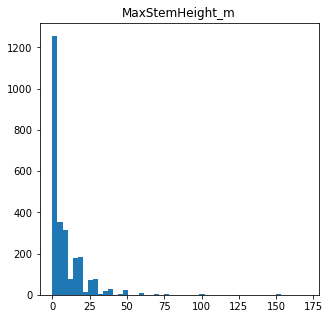

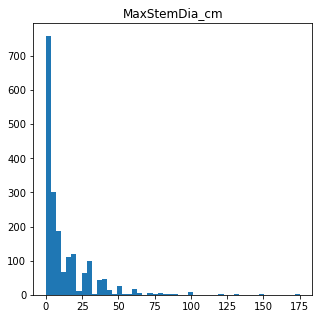

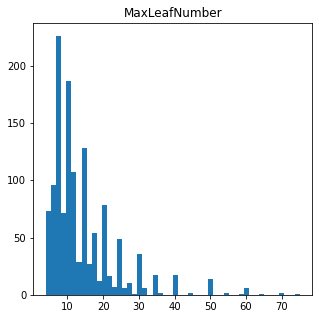

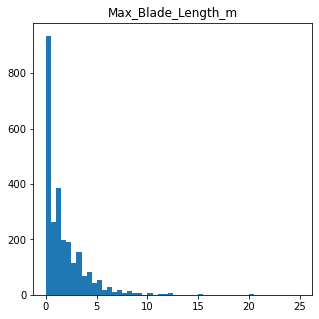

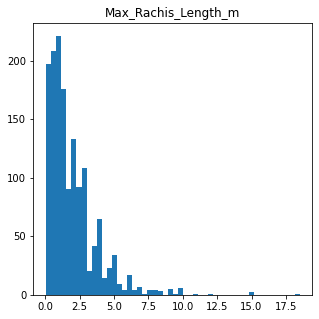

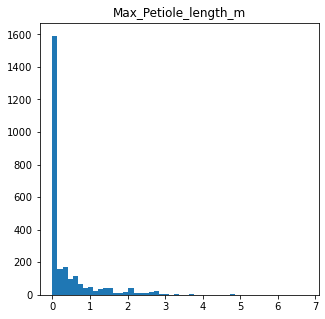

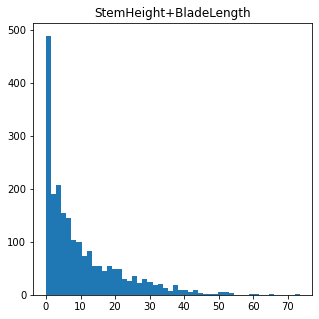

In [39]:
kissling=['MaxStemHeight_m','MaxStemDia_cm','MaxLeafNumber','Max_Blade_Length_m','Max_Rachis_Length_m','Max_Petiole_length_m','StemHeight+BladeLength']
palms_all_variables[kissling]=palms_all_variables[kissling].astype('float')
# palms_all_variables[kissling]=logMatrix(palms_all_variables[kissling].astype('float'))
for i in kissling:
    fig,ax=plt.subplots(figsize=(5,5))
    ax.hist(sorted(palms_all_variables[kissling][i].dropna()),bins=50)
    plt.title('%s'%(i))
    plt.show()

In [40]:
# morphological variables need log transformation.
# none has negative variables, so just to regular log transform
palms_all_variables[kissling].describe()
palms_all_variables[kissling]=logMatrix(palms_all_variables[kissling].astype('float'))
palms_all_variables[kissling].describe()

,MaxStemHeight_m,MaxStemDia_cm,MaxLeafNumber,Max_Blade_Length_m,Max_Rachis_Length_m,Max_Petiole_length_m,StemHeight+BladeLength
count,2624.000000,1909.000000,1284.000000,2624.000000,1493.000000,2624.000000,2157.000000
mean,0.674778,0.870438,1.119484,0.326229,0.411344,0.104709,0.796450
std,0.529826,0.467786,0.224973,0.284265,0.221341,0.161978,0.508344
min,0.000000,0.000000,0.698970,0.000000,0.021189,0.000000,0.000000
25%,0.000000,0.477121,0.954243,0.000000,0.243038,0.000000,0.447158
50%,0.698970,0.778151,1.079181,0.303196,0.397940,0.000000,0.845098
75%,1.113943,1.278754,1.255273,0.538447,0.562293,0.161368,1.204120
max,2.232996,2.245513,1.880814,1.414973,1.290035,0.889302,1.871573


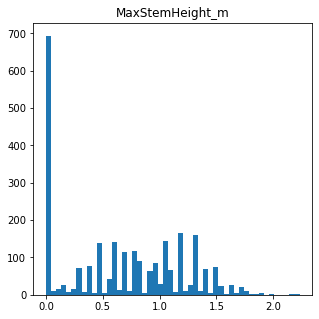

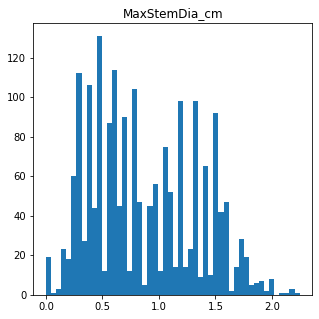

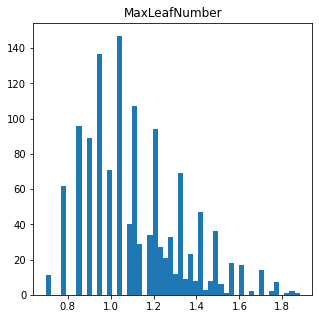

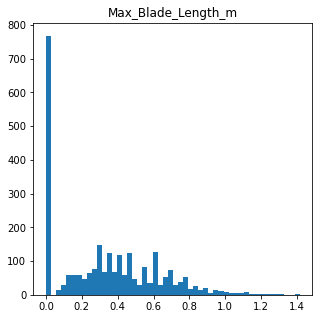

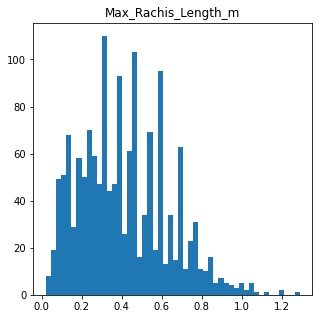

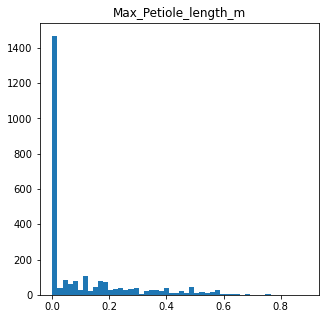

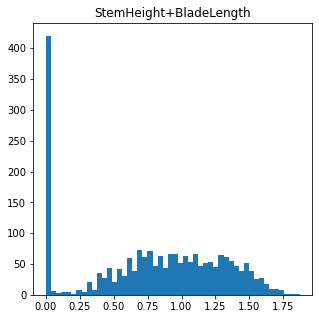

In [41]:
kissling=['MaxStemHeight_m','MaxStemDia_cm','MaxLeafNumber','Max_Blade_Length_m','Max_Rachis_Length_m','Max_Petiole_length_m','StemHeight+BladeLength']
palms_all_variables[kissling]=palms_all_variables[kissling].astype('float')
# palms_all_variables[kissling]=logMatrix(palms_all_variables[kissling].astype('float'))
for i in kissling:
    fig,ax=plt.subplots(figsize=(5,5))
    ax.hist(sorted(palms_all_variables[kissling][i]),bins=50)
    plt.title('%s'%(i))
    plt.show()

## 8. Checking Bio variables

Less species than the database above. We first cleaned the GBIF coordinate records and removed points falling on bodies of water, country centroids (< 5km from a centroid), coordinates in coutries where species are not native, and coordinates in botanical gardens or main cities. After the cleaning, we further deleted species with less than 3 unique coordinate records in GBIF.

let's check the coorelation between variables for the palm species remaining in the database.

bio1 and bio15 are a great combo of uncorrelated variables.
Bio4 isn't great. Bio3 is another posibility

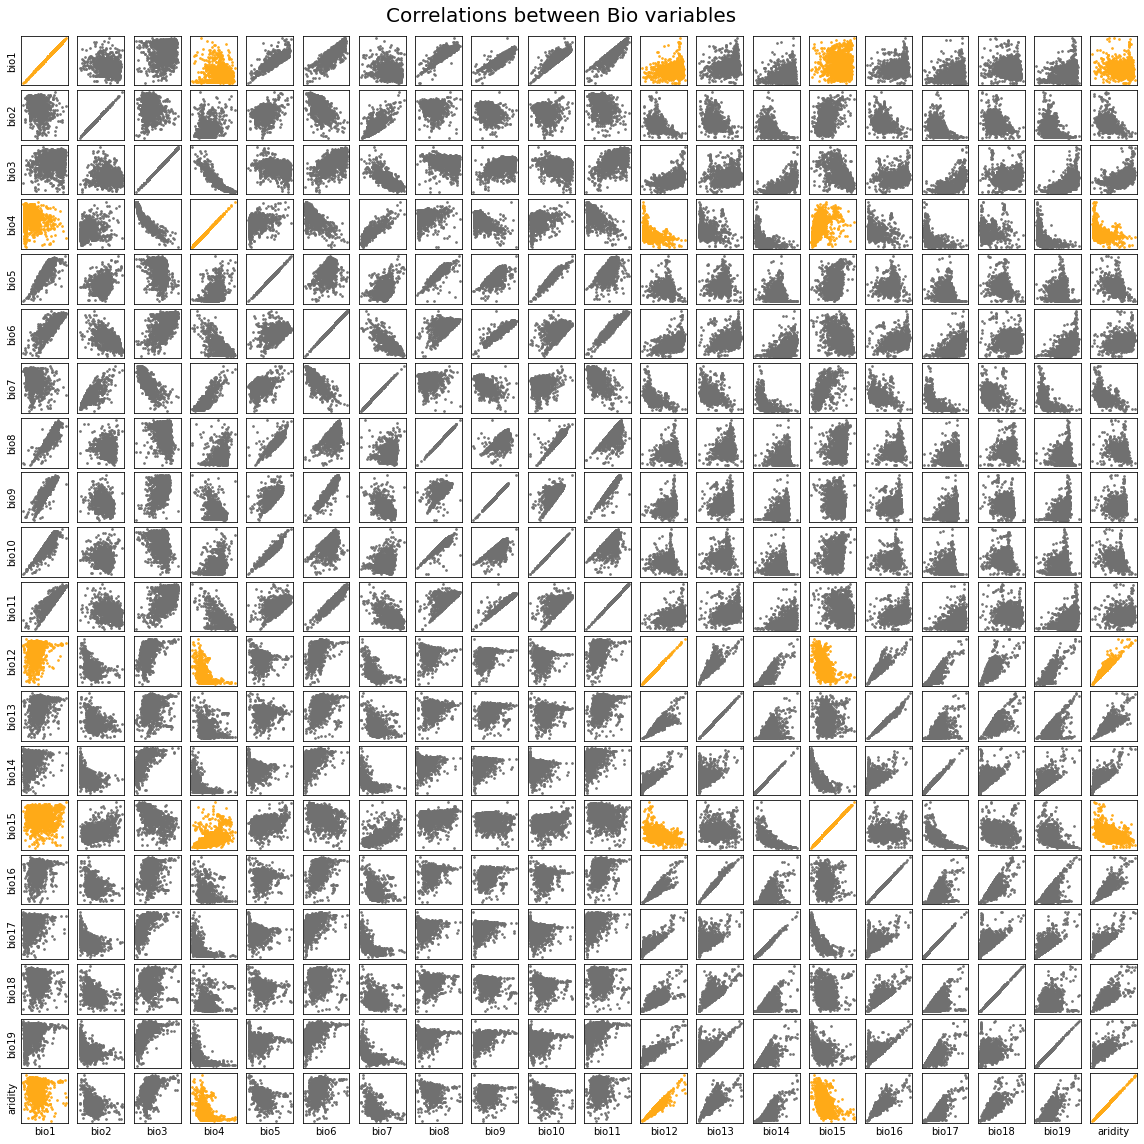

In [46]:
bio_var=['bio1','bio2','bio3','bio4','bio5','bio6','bio7','bio8','bio9','bio10','bio11','bio12','bio13','bio14','bio15','bio16','bio17','bio18','bio19','aridity']
using=['bio1','bio4','bio12','bio15','aridity']

fig=plt.figure(figsize=((len(bio_var)), (len(bio_var))),facecolor='w')
fig.suptitle('Correlations between Bio variables', size=20,y=0.9)
outer_grid=gridspec.GridSpec(len(bio_var),len(bio_var), wspace=0.2, hspace=0.1)
outer_grid.tight_layout(fig,rect=[0, 0.03, 1, 0.95]) #rect=[0, 0.03, 1, 0.95]

for j,(c,d) in enumerate(product(range(0,len(bio_var)),repeat=2)):
#     print(j,c,d)
    ax=plt.subplot(outer_grid[c,d])
    if c == len(bio_var)-1:
        ax.set_xlabel('%s'%(bio_var[d]))
    if d == 0:
        ax.set_ylabel('%s'%(bio_var[c]))
    if bio_var[c] in using and bio_var[d] in using:
        ax.scatter(palms_all_variables[bio_var[c]],palms_all_variables[bio_var[d]],s=3,color='#ffaa17',alpha=0.9)
    else:
        ax.scatter(palms_all_variables[bio_var[c]],palms_all_variables[bio_var[d]],s=3,color='#707070',alpha=0.9)
    plt.xticks(())
    plt.yticks(())
plt.show()

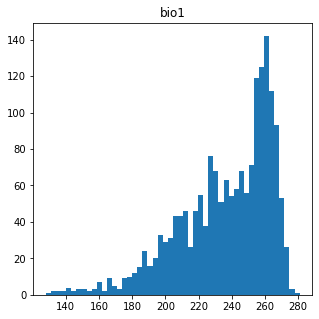

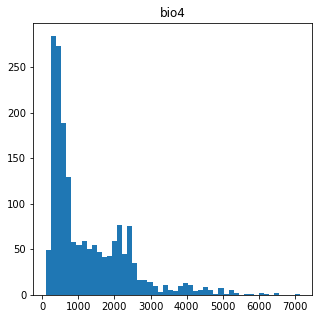

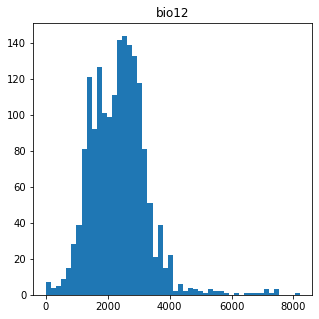

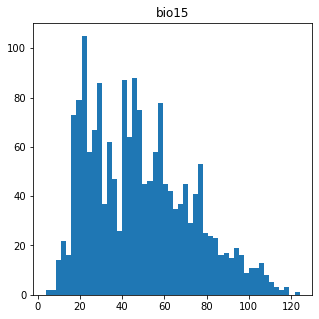

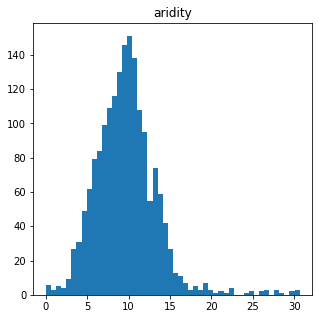

In [47]:
for i in using:
    fig,ax=plt.subplots(figsize=(5,5))
    ax.hist(sorted(palms_all_variables[using][i]),bins=50)
    plt.title('%s'%(i))
    plt.show()

In [8]:
# trasform the variables that we are interested in
#log transform bio4 (temp seasonality)
palms_all_variables[['bio4','bio12','bio15','aridity']]=logMatrix(palms_all_variables[['bio4','bio12','bio15','aridity']])
palms_all_variables[using].describe()

,bio1,bio4,bio12,bio15,aridity
count,1508.000000,1508.000000,1508.000000,1508.000000,1508.000000
mean,234.648541,2.972850,3.319886,1.652098,9.493717
std,27.952535,0.361359,0.218507,0.226358,3.792796
min,128.000000,2.037426,0.740363,0.698970,0.016917
25%,216.500000,2.662285,3.213850,1.491362,7.091693
50%,240.500000,2.940764,3.361681,1.681241,9.350903
75%,258.000000,3.307550,3.451153,1.819544,11.437676
max,281.000000,3.852602,3.913814,2.096910,30.654378


In [11]:
palms_all_variables['aridity'].describe()

count    1508.000000
mean        0.991846
std         0.167025
min         0.007286
25%         0.908039
50%         1.014978
75%         1.094739
max         1.500434
Name: aridity, dtype: float64

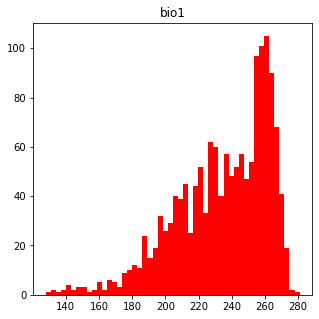

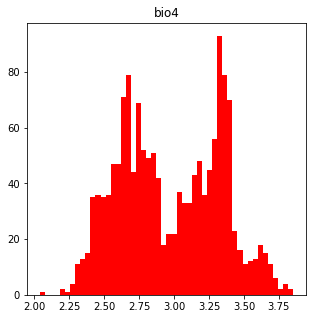

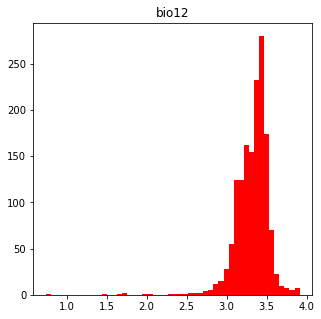

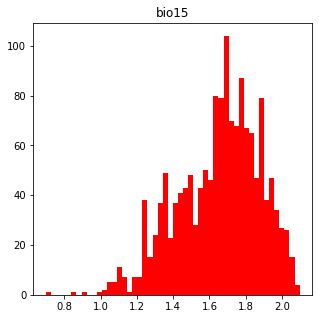

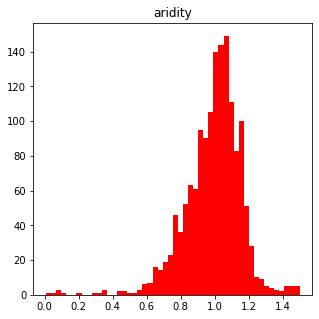

In [12]:
using=['bio1','bio4','bio12','bio15','aridity']
for i in using:
    fig,ax=plt.subplots(figsize=(5,5))
    ax.hist(sorted(palms_all_variables[using][i]),bins=50,color='r')
    plt.title('%s'%(i))
    plt.show()

## 9. Soil variables

Soil variables should be recoded. The classes in the dataset of harmonized soil traits has been multiplied by 0.01 and it is categorize as follows: Note that the classes used in the Soil Quality evaluation are:

1: No or slight limitations
2: Moderate limitations
3: Sever limitations
4: Very severe limitations
5: Mainly non-soil
6: Permafrost area
7: Water bodies

We multiplied by 100. Handeling integers is easier than handling floats. Then we will evaluate missing data and size of categories for every trait individually, in case we need to recategorize and organize the data.

The interpretation of each trait is:

**SQ1, Nutrient availability:** Soil texture, soil organic carbon, soil pH, total exchangeable bases

**SQ2, Nutrient retention capacity:** Soil Organic carbon, Soil texture, base saturation, cation exchange capacity of soil and of clay fraction

**SQ3, Rooting conditions:** Soil textures, bulk density, coarse fragments, vertic soil properties and soil phases affecting root penetration and soil depth and soil volume

**SQ4, Oxygen availability to roots:** Soil drainage and soil phases affecting soil drainage

**SQ5, Excess salts.:** Soil salinity, soil sodicity and soil phases influencing salt conditions

**SQ6, Toxicity:** Calcium carbonate and gypsum

**SQ7, Workability (constraining field management):** Soil texture, effective soil depth/volume, and soil phases constraining soil management (soil depth, rock outcrop, stoniness, gravel/concretions and hardpans)

We will consider SQ1, SQ2, SQ5, SQ6.

most palm species are distributed across the first 5 categories of soil traits. None of the categories has particularly bad sampling but the differences between species in a category can be as large as 1100 versus 77.

Now, we need to take either the mean or median of soil traits per species. According to the descriptions above, medians might be better.

Before: soil values are no longer integers. We need to convert them into ordinal categories and redistribute them.

**After talking, we decided to not re-bin the samples and treat soil variables as continuous (they are ordinal, but we will ignore that)**

In [51]:
palms_all_variables.columns
soil_columns=['nutrient_avail', 'nutrient_retention','rooting_conditions', 'oxygen_avail_toroots', 'excess_salts', 'toxicity', 'workability']
palms_all_variables[soil_columns].describe()

,nutrient_avail,nutrient_retention,rooting_conditions,oxygen_avail_toroots,excess_salts,toxicity,workability
count,1785.000000,1785.00000,1785.000000,1785.000000,1785.000000,1785.000000,1785.000000
mean,0.750980,0.60112,0.584034,0.445658,0.405322,0.398039,0.558263
std,1.196632,0.98047,1.088797,0.807486,0.717924,0.707282,1.016799
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
max,7.000000,7.00000,7.000000,7.000000,7.000000,7.000000,7.000000


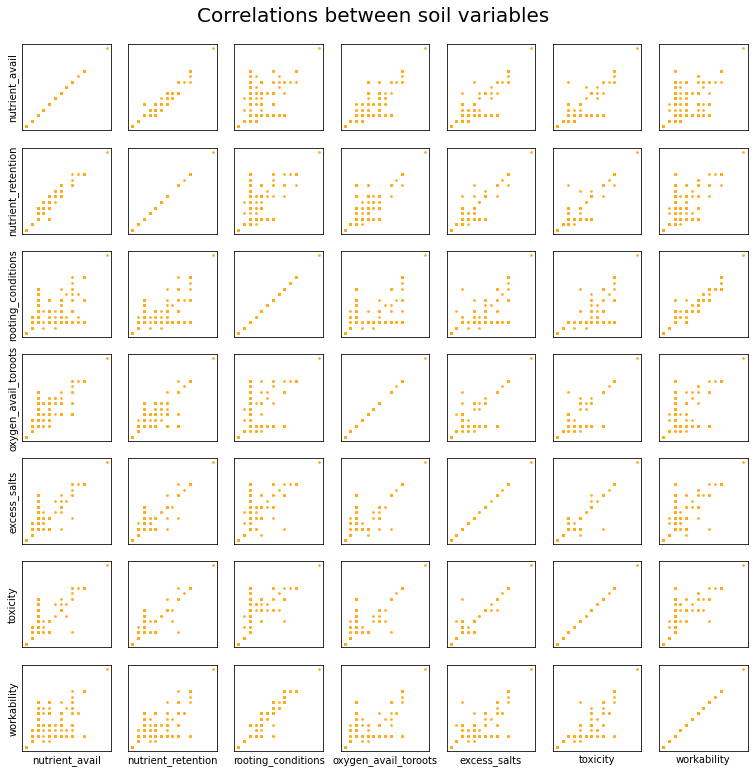

In [53]:
## filter out np.nans in shape before making the figures!
## visualizing soil variables ("continuos" but really ordinal)
fig=plt.figure(figsize=((len(soil_columns)+6), (len(soil_columns)+6)),facecolor='w')
fig.suptitle('Correlations between soil variables', size=20,y=0.92)
outer_grid=gridspec.GridSpec(len(soil_columns),len(soil_columns), wspace=0.2, hspace=0.2)
outer_grid.tight_layout(fig,rect=[0, 0.04, 1, 0.96]) #rect=[0, 0.03, 1, 0.95]

for j,(c,d) in enumerate(product(range(0,len(soil_columns)),repeat=2)):
#     print(j,c,d)
    ax=plt.subplot(outer_grid[c,d])
    if c == len(soil_columns)-1:
        ax.set_xlabel('%s'%(soil_columns[d]))
    if d == 0:
        ax.set_ylabel('%s'%(soil_columns[c]))
    temp=palms_all_variables[soil_columns].dropna()
    ax.scatter(temp[soil_columns[c]],temp[soil_columns[d]],s=3,color='#ffaa17',alpha=0.9) # #707070
    plt.xticks((),rotation=90)
    plt.yticks((),rotation=90)
plt.show()

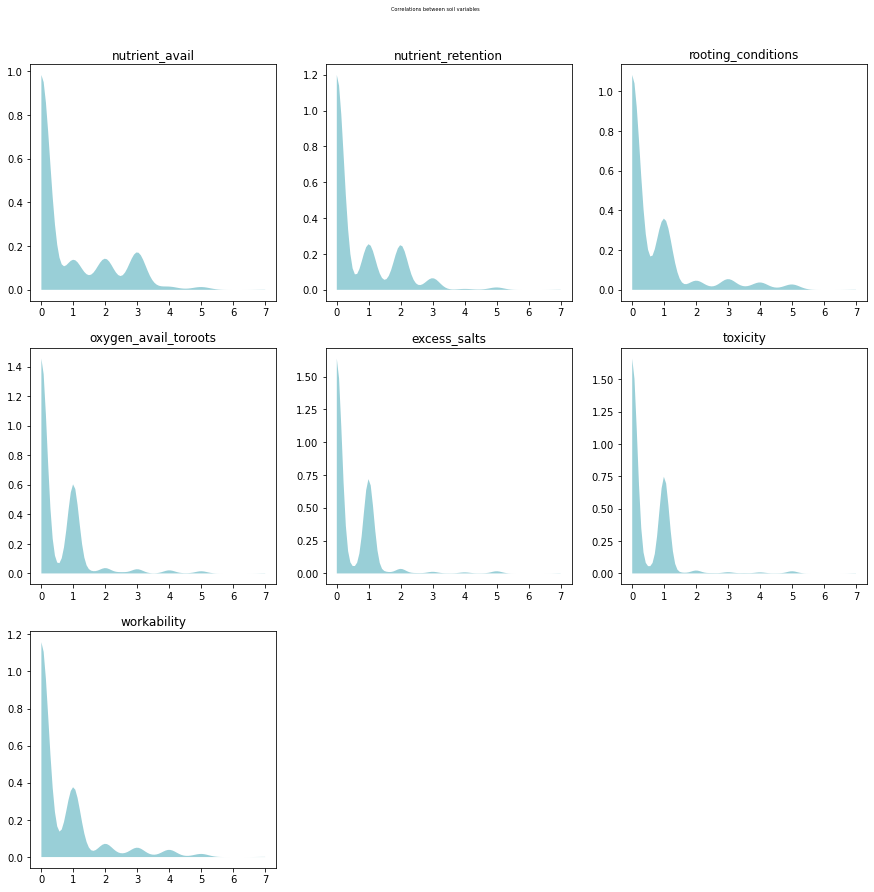

In [54]:
## filter out np.nans in shape before making the figures!
## visualizing soil variables ("continuos" but really ordinal)
## 7 soil variables

fig=plt.figure(figsize=(15,20),facecolor='w')
fig.suptitle('Correlations between soil variables', size=5,y=0.92)
outer_grid=gridspec.GridSpec(4,3, wspace=0.2, hspace=0.2)
outer_grid.tight_layout(fig,rect=[0, 0.04, 1, 0.96]) #rect=[0, 0.03, 1, 0.95]

for xx in range(0,3,1):
    ax=plt.subplot(outer_grid[0,xx])
    values=palms_all_variables[soil_columns[xx]].dropna().astype('float').values
    kde=gaussian_kde(values)
    x_grid=np.linspace(min(values),max(values),100)
    ax.fill_between(x_grid,kde(x_grid),alpha=0.4,edgecolor='none',facecolor='#00879c')
    plt.title('%s'%(soil_columns[xx]))    
    
for xx in range(0,3,1):
    ax=plt.subplot(outer_grid[1,xx])
    values=palms_all_variables[soil_columns[xx+3]].dropna().astype('float').values
    kde=gaussian_kde(values)
    x_grid=np.linspace(min(values),max(values),100)
    ax.fill_between(x_grid,kde(x_grid),alpha=0.4,edgecolor='none',facecolor='#00879c')
    plt.title('%s'%(soil_columns[xx+3]))
    
ax=plt.subplot(outer_grid[2,0])
values=palms_all_variables[soil_columns[6]].dropna().astype('float').values
kde=gaussian_kde(values)
x_grid=np.linspace(min(values),max(values),100)
ax.fill_between(x_grid,kde(x_grid),alpha=0.4,edgecolor='none',facecolor='#00879c')
plt.title('%s'%(soil_columns[6]))

plt.show()

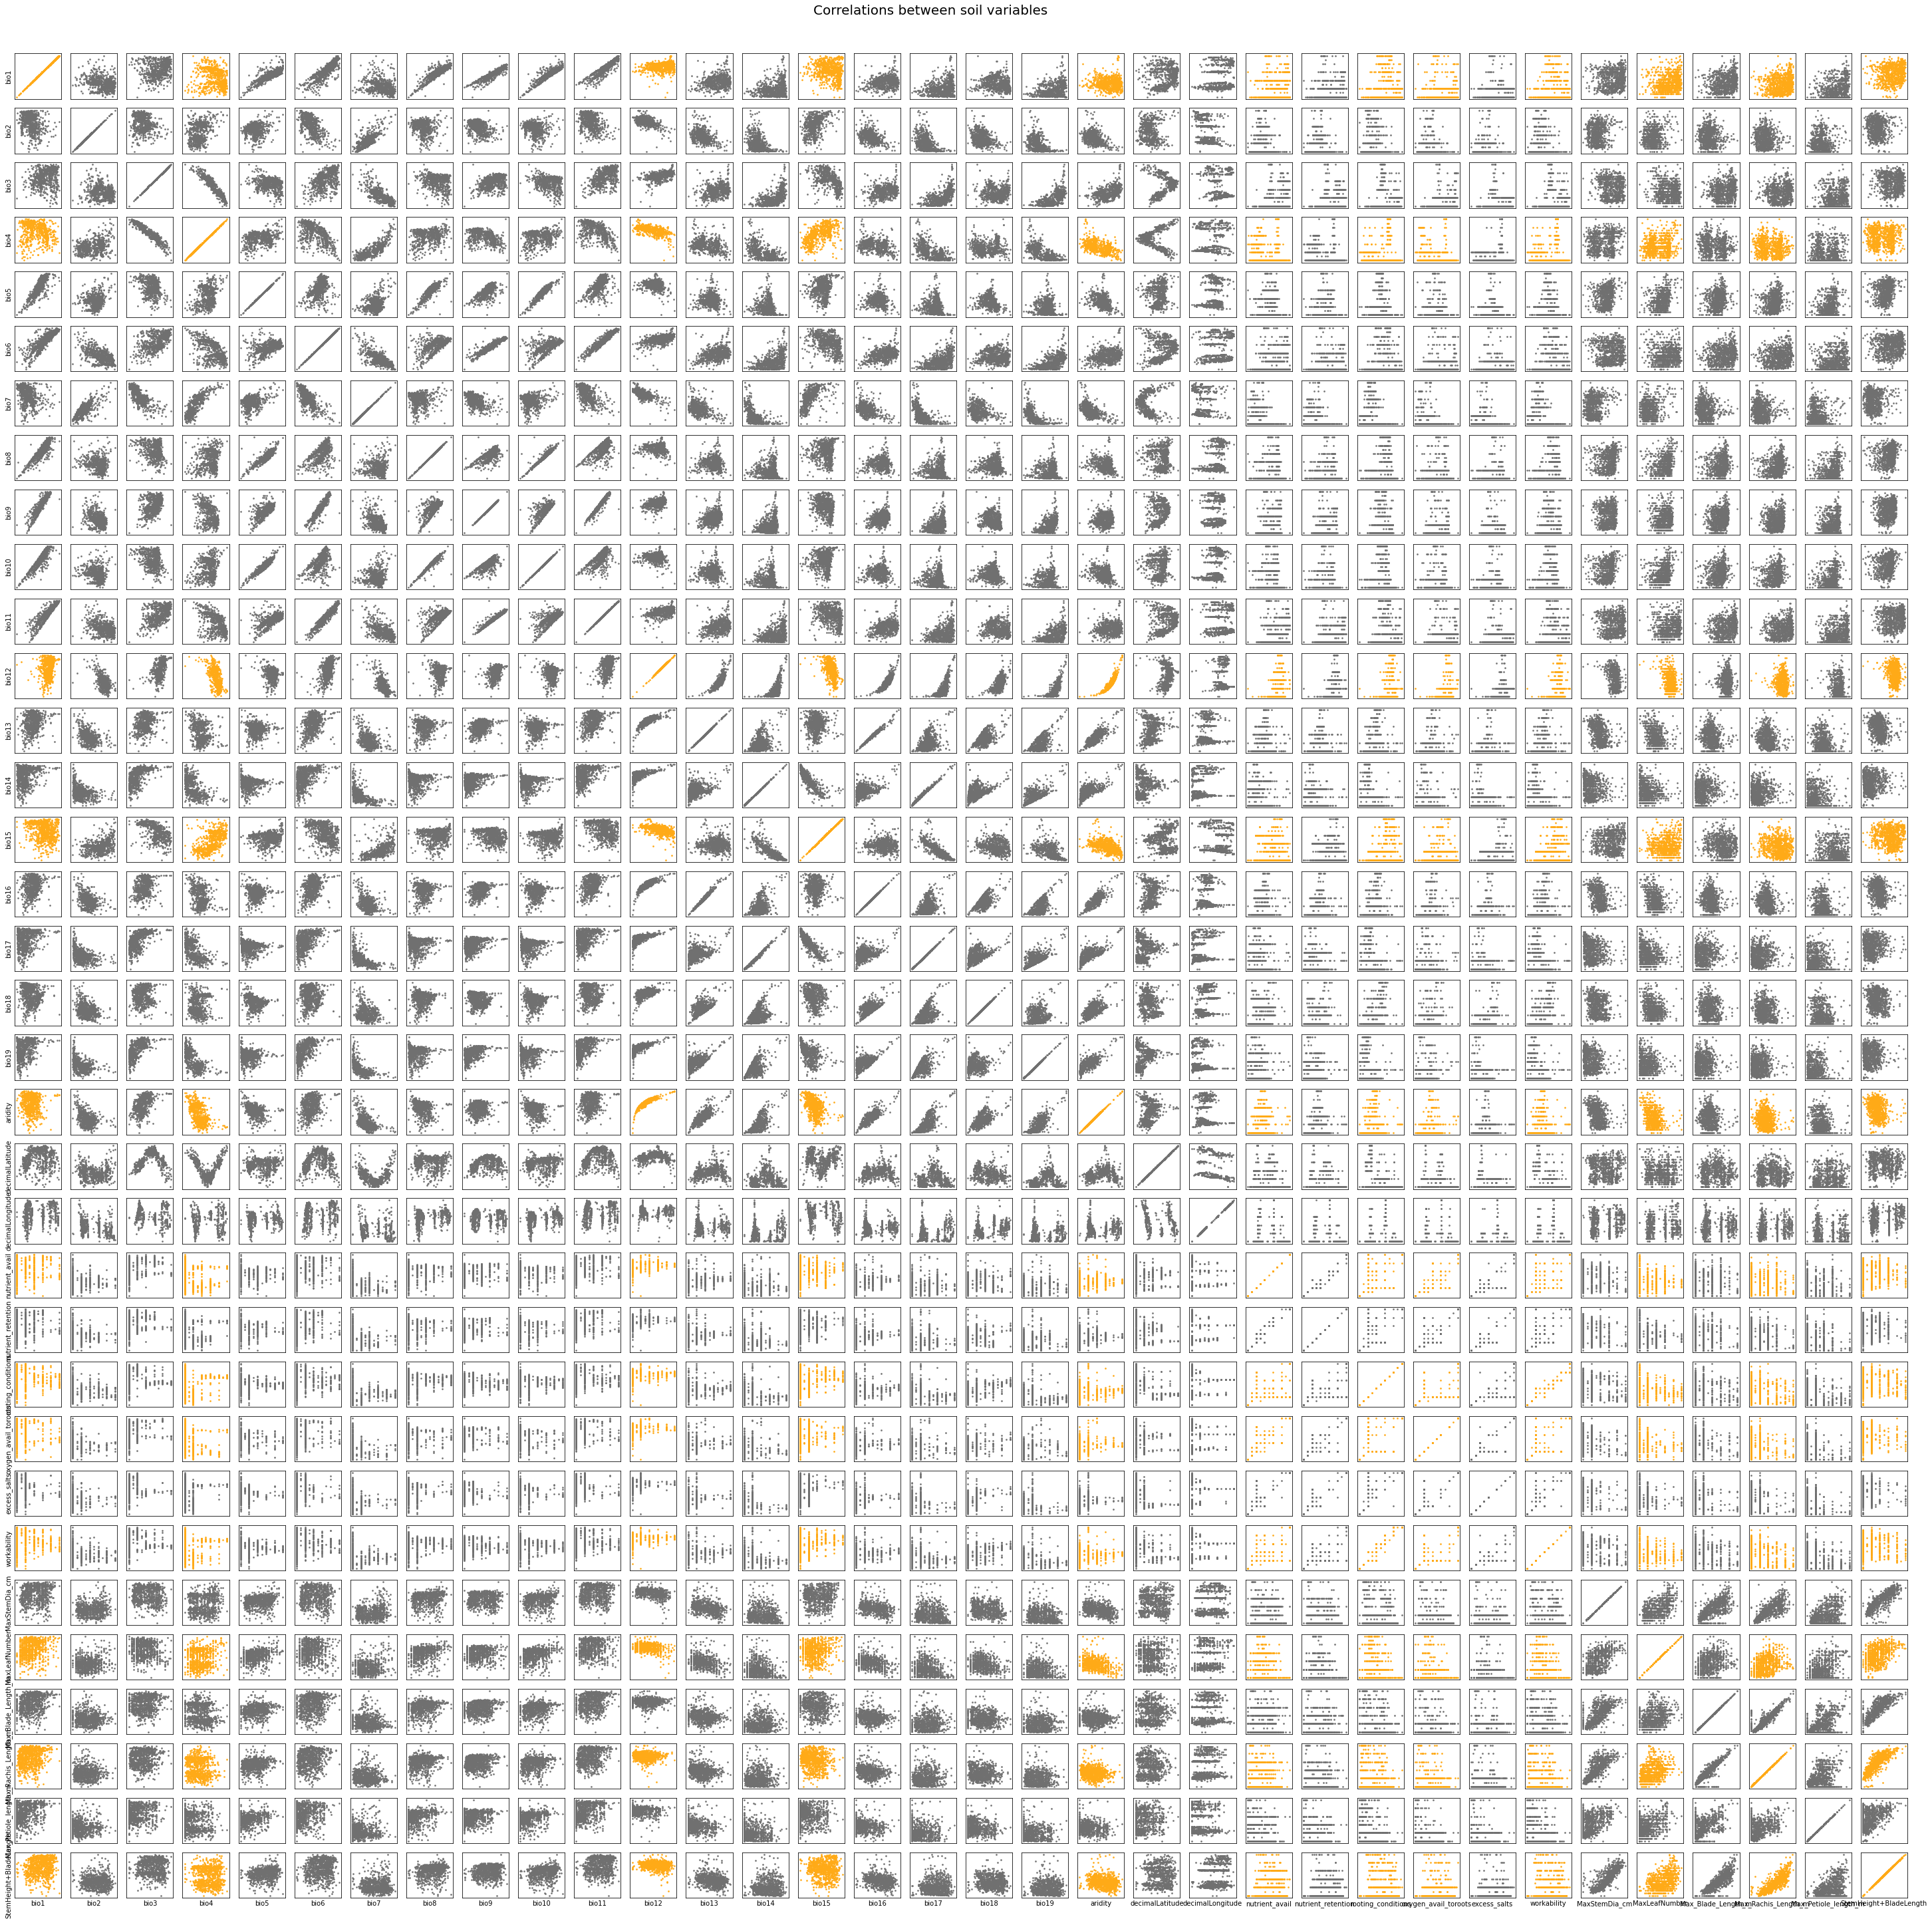

In [64]:
## correlations between soil variables and the rest of variables
all_var=['bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19','aridity','decimalLatitude','decimalLongitude', 'nutrient_avail', 'nutrient_retention',
       'rooting_conditions', 'oxygen_avail_toroots', 'excess_salts','workability','MaxStemDia_cm', 'MaxLeafNumber','Max_Blade_Length_m','Max_Rachis_Length_m', 'Max_Petiole_length_m', 'StemHeight+BladeLength']
using=['bio1','bio4','bio12','bio15','aridity', 'nutrient_avail','rooting_conditions', 'oxygen_avail_toroots','workability', 'MaxLeafNumber','Max_Rachis_Length_m','StemHeight+BladeLength']
# palms_all_variables.columns

fig=plt.figure(figsize=((len(all_var)*1.5), (len(all_var)*1.5)),facecolor='w')
fig.suptitle('Correlations between soil variables', size=20,y=0.9)
outer_grid=gridspec.GridSpec(len(all_var),len(all_var), wspace=0.2, hspace=0.2)
outer_grid.tight_layout(fig,rect=[0, 0.04, 1, 0.96]) #rect=[0, 0.03, 1, 0.95]

temp=palms_all_variables[all_var].dropna()
for j,(c,d) in enumerate(product(range(0,len(all_var)),repeat=2)):
#     print(j,c,d)
    ax=plt.subplot(outer_grid[c,d])
    if c == len(all_var)-1:
        ax.set_xlabel('%s'%(all_var[d]))
        
    if d == 0:
        ax.set_ylabel('%s'%(all_var[c]))
        
    if all_var[c] in using and all_var[d] in using:
        ax.scatter(temp[all_var[c]],temp[all_var[d]],s=3,color='#ffaa17',alpha=0.9)
    else:
        ax.scatter(temp[all_var[c]],temp[all_var[d]],s=3,color='#707070',alpha=0.9)        

    plt.xticks((),rotation=45)
    plt.yticks((),rotation=45)
plt.show()

### Correlations between bio and kissling measurements

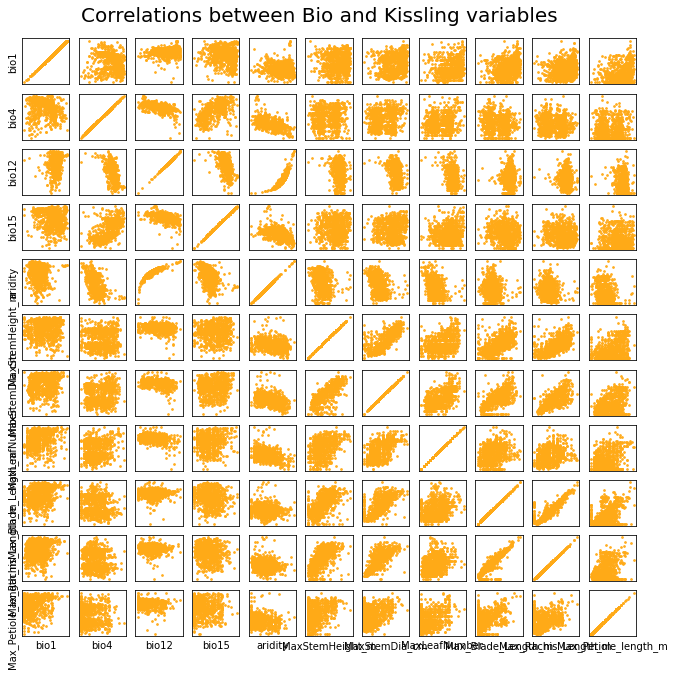

In [68]:
bio_kissling=['bio1','bio4','bio12','bio15','aridity','MaxStemHeight_m', 'MaxStemDia_cm', 'MaxLeafNumber', 'Max_Blade_Length_m',
       'Max_Rachis_Length_m', 'Max_Petiole_length_m']


fig=plt.figure(figsize=((len(bio_kissling)), (len(bio_kissling))),facecolor='w')
fig.suptitle('Correlations between Bio and Kissling variables', size=20,y=0.92)
outer_grid=gridspec.GridSpec(len(bio_kissling),len(bio_kissling), wspace=0.2, hspace=0.2)
outer_grid.tight_layout(fig,rect=[0, 0.04, 1, 0.96]) #rect=[0, 0.03, 1, 0.95]

for j,(c,d) in enumerate(product(range(0,len(bio_kissling)),repeat=2)):
#     print(j,c,d)
    ax=plt.subplot(outer_grid[c,d])
    if c == len(bio_kissling)-1:
        ax.set_xlabel('%s'%(bio_kissling[d]))
    if d == 0:
        ax.set_ylabel('%s'%(bio_kissling[c]))
    temp=palms_all_variables[bio_kissling].dropna()
    ax.scatter(temp[bio_kissling[c]],temp[bio_kissling[d]],s=3,color='#ffaa17',alpha=0.9) # #707070
    plt.xticks((),rotation=45)
    plt.yticks((),rotation=45)
plt.show()

'Max_Rachis_Length_m' and 'Max_Blade_Length_m' are heavily correlated.
Moreover, we can define palm heigth as MaxStemHeight+MaxLeaf

StemHeight+BladeLength

Again, 'Max_Rachis_Length_m' and 'StemHeight+BladeLength' are correlated even though rachis is measured across the blade without the petiol. We will keep 'StemHeight+BladeLength'. Also, 'Max_Rachis_Length_m' looks slightly correlated with 'MaxStemDia_cm'. In turn, 'StemHeight+BladeLength' is correlated with 'MaxStemDia_cm'.

Let's try removing both 'Max_Rachis_Length_m' and 'MaxStemDia_cm'.

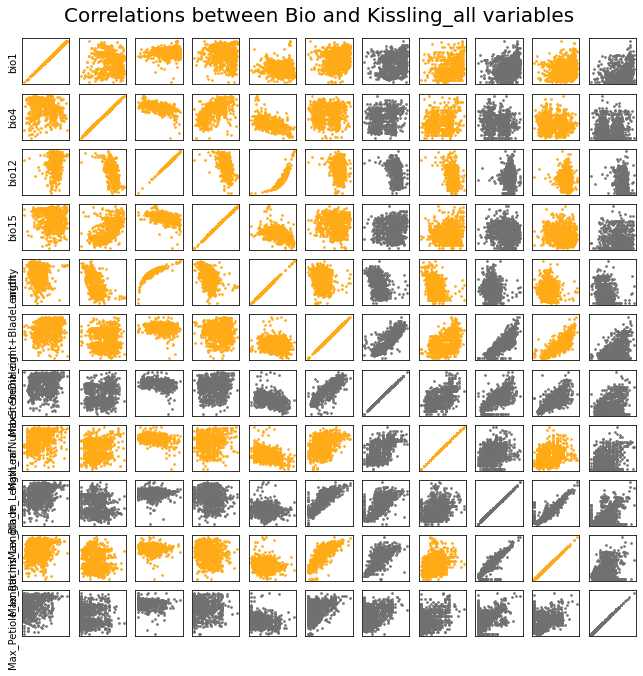

In [69]:
# For the paper figure:
bio_kissling_all=['bio1','bio4','bio12','bio15','aridity','StemHeight+BladeLength','MaxStemDia_cm', 'MaxLeafNumber',
                  'Max_Blade_Length_m','Max_Rachis_Length_m','Max_Petiole_length_m']
bio_kissling3=['bio1','bio4','bio12','bio15','aridity','MaxLeafNumber','Max_Rachis_Length_m', 'StemHeight+BladeLength']

fig=plt.figure(figsize=((len(bio_kissling_all)), (len(bio_kissling_all))),facecolor='w')
fig.suptitle('Correlations between Bio and Kissling_all variables', size=20,y=0.92)
outer_grid=gridspec.GridSpec(len(bio_kissling_all),len(bio_kissling_all), wspace=0.2, hspace=0.2)
outer_grid.tight_layout(fig,rect=[0, 0.04, 1, 0.96]) #rect=[0, 0.03, 1, 0.95]

for j,(c,d) in enumerate(product(range(0,len(bio_kissling_all)),repeat=2)):
#     print(j,c,d)
    ax=plt.subplot(outer_grid[c,d])
    if c == len(bio_kissling_all):
        ax.set_xlabel('%s'%(bio_kissling_all[d]))
    if d == 0:
        ax.set_ylabel('%s'%(bio_kissling_all[c]))
    temp=palms_all_variables[bio_kissling_all].dropna()
    if bio_kissling_all[c] in bio_kissling3 and bio_kissling_all[d] in bio_kissling3:
        ax.scatter(temp[bio_kissling_all[c]],temp[bio_kissling_all[d]],s=3,color='#ffaa17',alpha=0.9) # #707070
    else:
        ax.scatter(temp[bio_kissling_all[c]],temp[bio_kissling_all[d]],s=3,color='#707070',alpha=0.9) # #707070
#     plt.setp(ax.yaxis, rotation=45)
    ax.tick_params(labelrotation=45)
    plt.xticks(())
    plt.yticks(())
plt.show()

### -> Checkpoint DB with BIOCLIM, soil, Kissling, after transforming

In [70]:
palms_all_variables.to_csv('../data_files/palms_all_variables_temp3_20210210.txt',sep='\t')
# palms_all_variables=pd.read_csv('../data_files/palms_all_variables_temp3_20210210.txt',sep='\t')
palms_all_variables

,index,species,Unnamed: 0,Unnamed: 0.1,bio1,bio2,bio3,bio4,bio5,bio6,...,Climbing,Acaulescent,MaxStemHeight_m,MaxStemDia_cm,MaxLeafNumber,Max_Blade_Length_m,Max_Rachis_Length_m,Max_Petiole_length_m,UnderstoreyCanopy,StemHeight+BladeLength
0,0,Acoelorraphe_wrightii,79710.0,79711.0,255.0,94.0,64.0,3.214579,324.0,182.0,...,0.0,0.0,1.004321,1.204120,1.414973,0.361728,0.230449,0.217484,canopy,1.103804
1,1,Acrocomia_aculeata,41905.0,41906.0,252.0,108.0,69.0,3.183270,328.0,165.0,...,0.0,0.0,1.113943,1.707570,1.491362,0.653213,0.544068,0.000000,canopy,1.301030
2,2,Acrocomia_crispa,31242.0,31243.0,247.0,97.0,62.0,3.287578,320.0,163.0,...,0.0,0.0,1.278754,1.556303,1.204120,0.602060,NaN,0.217484,canopy,1.397940
3,3,Acrocomia_emensis,66723.0,66724.0,203.0,120.0,64.0,3.344981,281.0,99.0,...,0.0,1.0,0.000000,NaN,NaN,0.000000,NaN,0.000000,understorey,0.000000
4,4,Acrocomia_glaucescens,49650.5,49651.5,240.0,127.0,67.0,3.205475,321.5,133.0,...,0.0,0.0,0.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,834,Saribus_papuanus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.491362,1.491362,1.612784,0.000000,NaN,0.477121,canopy,1.491362
2620,835,Calamus_rarispinosus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,1.322219,0.544068,NaN,0.301030,0.301030,0.000000,canopy,NaN
2621,836,Attalea_guianensis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.000000,NaN,NaN,0.000000,NaN,0.000000,understorey,0.000000
2622,837,Clinostigma_carolinense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,0.000000


## 10. Annotating biomes

In [71]:
# create dictionaries from the biome database. To make things faster, the dictionaries will be used to map the data to the main DB instead of using embebed loops, as I foolishly do at some point above. I'll have to fix that some time in the future.
biome_columns=['1_Tropical_and_subtropical_moist_broadleaf_forests','2_Tropical_and_subtropical_dry_broadleaf_forests', '3_Tropical_and_subtropical_coniferous_forests','4_Temperate_broadleaf_and_mixed_forests','5_Temperate_coniferous_forest',
       '7_Tropical_and_subtropical_grasslands_savannas_and_shrublands','8_Temperate_grasslands_savannas_and_shrublands','12_Mediterranean_Forests_woodlands_and_scrubs','13_Desert_and_xeric_shrublands', 'species_name']

biome_metadict={}
for col in biome_columns:
    tempdict=dict(zip(biome_bdb_sf['species_name'],biome_bdb_sf[col]))
    biome_metadict[col]=tempdict
# biome_metadict

# annotate the main DB
for key,value in biome_metadict.items():
    palms_all_variables[key]=palms_all_variables['species'].map(value)
palms_all_variables[['2_Tropical_and_subtropical_dry_broadleaf_forests','species']]

palms_all_variables[biome_columns].describe()

,1_Tropical_and_subtropical_moist_broadleaf_forests,2_Tropical_and_subtropical_dry_broadleaf_forests,3_Tropical_and_subtropical_coniferous_forests,4_Temperate_broadleaf_and_mixed_forests,5_Temperate_coniferous_forest,7_Tropical_and_subtropical_grasslands_savannas_and_shrublands,8_Temperate_grasslands_savannas_and_shrublands,12_Mediterranean_Forests_woodlands_and_scrubs,13_Desert_and_xeric_shrublands
count,2548.000000,2548.000000,2548.000000,2548.000000,2548.000000,2548.000000,2548.000000,2548.000000,2548.000000
mean,0.895604,0.061617,0.001570,0.001962,0.002747,0.047881,0.000392,0.002355,0.012559
std,0.305833,0.240506,0.039598,0.044263,0.052352,0.213556,0.019811,0.048479,0.111382
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Understanding the forest categories to know what species to consider for canopy and understory analyses

**1_Tropical_and_subtropical_moist_broadleaf_forests (has canopy): 2282 species**  
ow variability in annual temperature and high levels of rainfall (>200 centimetres (79 in) annually). Forest composition is dominated by evergreen and semi-evergreen deciduous tree species. The canopy can be divided into five layers: overstory canopy with emergent crowns, a medium layer of canopy, lower canopy, shrub level, and finally understory.

**2_Tropical_and_subtropical_dry_broadleaf_forests (has canopy) 157 species:**  
Though these forests occur in climates that are warm year-round, and may receive several hundred centimeters of rain per year, they have long dry seasons which last several months and vary with geographic location. Deciduous trees predominate in most of these forests, and during the drought a leafless period occurs, which varies with species type. Because trees lose moisture through their leaves, the shedding of leaves allows trees such as teak and mountain ebony to conserve water during dry periods. The newly bare trees open up the canopy layer, enabling sunlight to reach ground level and facilitate the growth of thick underbrush. Trees on moister sites and those with access to ground water tend to be evergreen. Infertile sites also tend to support evergreen trees. 

**3_Tropical_and_subtropical_coniferous_forests (has cannopy) 4 species:**  
 These forests are found predominantly in North and Central America and experience low levels of precipitation and moderate variability in temperature. Tropical and subtropical coniferous forests are characterized by diverse species of conifers, whose needles are adapted to deal with the variable climatic conditions. These biomes feature a thick, closed canopy which blocks light to the floor and allows little underbrush. As a result, the ground is often covered with fungi and ferns.

**4_Temperate_broadleaf_and_mixed_forests (has cannopy) 5 species:**  
These forests are richest and most distinctive in central China and eastern North America, with some other globally distinctive ecoregions in the Caucasus, the Himalayas, Southern Europe, Australasia, southern South America and the Russian Far East. The uppermost layer is the canopy composed of tall mature trees ranging from 30 to 61 m (100 to 200 ft) high. Below the canopy is the three-layered, shade-tolerant understory that is roughly 9 to 15 m (30 to 50 ft) shorter than the canopy. The top layer of the understory is the sub-canopy composed of smaller mature trees, saplings, and suppressed juvenile canopy layer trees awaiting an opening in the canopy. Below the sub-canopy is the shrub layer, composed of low growing woody plants. Typically the lowest growing (and most diverse) layer is the ground cover or herbaceous layer.

**5_Temperate_coniferous_forest (has cannopy) 7 species:**  
are found predominantly in areas with warm summers and cool winters, and vary in their kinds of plant life. In some, needleleaf trees dominate, while others are home primarily to broadleaf evergreen trees or a mix of both tree types. A separate habitat type, the tropical coniferous forests, occurs in more tropical climates. Temperate coniferous forests are common in the coastal areas of regions that have mild winters and heavy rainfall, or inland in drier climates or montane areas. Many species of trees inhabit these forests including pine, cedar, fir, and redwood. The understory also contains a wide variety of herbaceous and shrub species. Structurally, these forests are rather simple, consisting of 2 layers generally: an overstory and understory. However, some forests may support a layer of shrubs.

**7_Tropical_and_subtropical_grasslands_savannas_and_shrublands 122 species:**  
The biome is dominated by grass and/or shrubs located in semi-arid to semi-humid climate regions of subtropical and tropical latitudes. Grassland is dominated by grass and other herbaceous plants. Savanna is grassland with scattered trees. Shrubland is dominated by woody or herbaceous shrubs. Large expanses of land in the tropics do not receive enough rainfall to support extensive tree cover. The tropical and subtropical grasslands, savannas, and shrublands are characterized by rainfall levels between 90–150 centimetres (35–59 in) per year. Rainfall can be highly seasonal, with the entire year's rainfall sometimes occurring within a couple of weeks. African savannas occur between forest or woodland regions and grassland regions. Flora includes acacia and baobab trees, grass, and low shrubs. Acacia trees lose their leaves in the dry season to conserve moisture, while the baobab stores water in its trunk for the dry season. Many of these savannas are in Africa.

**8_Temperate_grasslands_savannas_and_shrublands 1 species:**  
The predominant vegetation in this biome consists of grass and/or shrubs. The climate is temperate and ranges from semi-arid to semi-humid. The habitat type differs from tropical grasslands in the annual temperature regime as well as the types of species found here. The habitat type is known as prairie in North America, pampas in South America, veld in Southern Africa and steppe in Asia. Generally speaking, these regions are devoid of trees, except for riparian or gallery forests associated with streams and rivers.

**12_Mediterranean_Forests_woodlands_and_scrubs (complex, check if there are palm species here and discuss) 6 species:**  
The biome is generally characterized by dry summers and rainy winters, although in some areas rainfall may be uniform. Summers are typically hot in low-lying inland locations but can be cool near colder seas. Winters are typically mild to cool in low-lying locations but can be cold in inland and higher locations. All these ecoregions are highly distinctive, collectively harboring 10% of the Earth's plant species. Vegetation types range from forests to woodlands, savannas, shrublands, and grasslands; "mosaic habitat" landscapes are common, where differing vegetation types are interleaved with one another in complex patterns created by variations in soil, topography, exposure to wind and sun, and fire history. Much of the woody vegetation in Mediterranean-climate regions is sclerophyll, which means 'hard-leaved' in Greek. Sclerophyll vegetation generally has small, dark leaves covered with a waxy outer layer to retain moisture in the dry summer months. 

**13_Desert_and_xeric_shrublands 32 species:**  
Deserts and xeric shrublands form the largest terrestrial biome, covering 19% of Earth's land surface area. Ecoregions in this habitat type vary greatly in the amount of annual rainfall they receive, usually less than 250 millimetres (10 in) annually except in the margins. Generally evaporation exceeds rainfall in these ecoregions. Temperature variability is also diverse in these lands. Many deserts, such as the Sahara, are hot year-round, but others, such as East Asia's Gobi, become quite cold in winter. Temperature extremes are a characteristic of most deserts. High daytime temperatures give way to cold nights because there is no insulation provided by humidity and cloud cover. The diversity of climatic conditions, though quite harsh, supports a rich array of habitats. Many of these habitats are ephemeral in nature, reflecting the paucity and seasonality of available water. Woody-stemmed shrubs and plants characterize vegetation in these regions. Above all, these plants have evolved to minimize water loss. Animal biodiversity is equally well adapted and quite diverse.




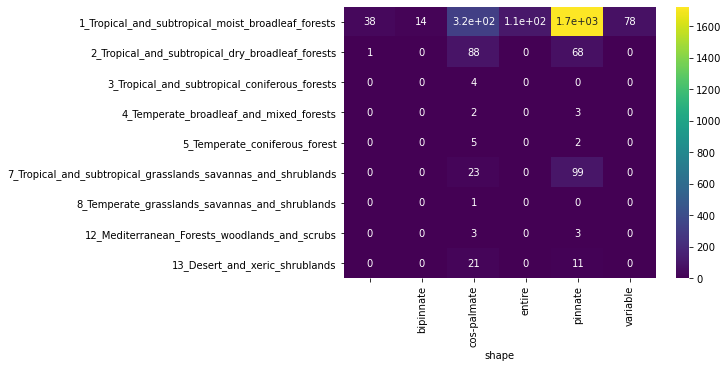

In [72]:
palms_all_variables[palms_all_variables['1_Tropical_and_subtropical_moist_broadleaf_forests']==1][['species','1_Tropical_and_subtropical_moist_broadleaf_forests']]
palms_all_variables[palms_all_variables['13_Desert_and_xeric_shrublands']==1]['shape'].describe()

# for col in ['1_Tropical_and_subtropical_moist_broadleaf_forests','2_Tropical_and_subtropical_dry_broadleaf_forests', '3_Tropical_and_subtropical_coniferous_forests','4_Temperate_broadleaf_and_mixed_forests','5_Temperate_coniferous_forest',
#        '7_Tropical_and_subtropical_grasslands_savannas_and_shrublands','8_Temperate_grasslands_savannas_and_shrublands','12_Mediterranean_Forests_woodlands_and_scrubs','13_Desert_and_xeric_shrublands']:
byshape=palms_all_variables.groupby('shape')[['1_Tropical_and_subtropical_moist_broadleaf_forests','2_Tropical_and_subtropical_dry_broadleaf_forests', '3_Tropical_and_subtropical_coniferous_forests','4_Temperate_broadleaf_and_mixed_forests','5_Temperate_coniferous_forest',
       '7_Tropical_and_subtropical_grasslands_savannas_and_shrublands','8_Temperate_grasslands_savannas_and_shrublands','12_Mediterranean_Forests_woodlands_and_scrubs','13_Desert_and_xeric_shrublands']].sum()

fig,ax=plt.subplots(figsize=(7,5),facecolor='w')
sns.heatmap(byshape.T,annot=True,cmap='viridis',ax=ax)
plt.savefig('./habitat_heatmap.pdf',bpi=300)
plt.show()

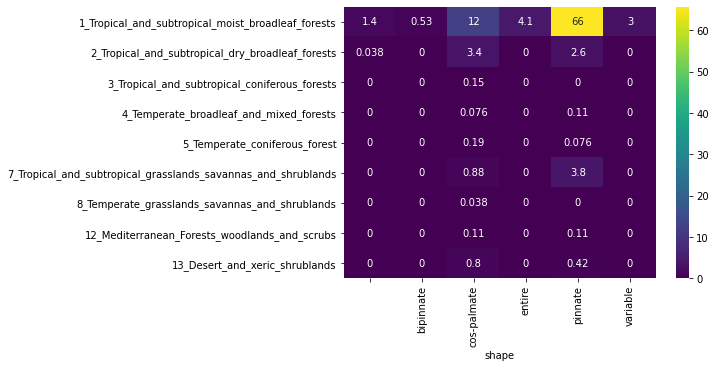

In [83]:
palms_all_variables[palms_all_variables['1_Tropical_and_subtropical_moist_broadleaf_forests']==1][['species','1_Tropical_and_subtropical_moist_broadleaf_forests']]
palms_all_variables[palms_all_variables['13_Desert_and_xeric_shrublands']==1]['shape'].describe()

total_palm_lineages=len(palms_all_variables)

byshape=palms_all_variables.groupby('shape')[['1_Tropical_and_subtropical_moist_broadleaf_forests','2_Tropical_and_subtropical_dry_broadleaf_forests', '3_Tropical_and_subtropical_coniferous_forests','4_Temperate_broadleaf_and_mixed_forests','5_Temperate_coniferous_forest',
       '7_Tropical_and_subtropical_grasslands_savannas_and_shrublands','8_Temperate_grasslands_savannas_and_shrublands','12_Mediterranean_Forests_woodlands_and_scrubs','13_Desert_and_xeric_shrublands']].sum()# .apply(lambda x:100 * x / total_palm_lineages)

byshape=(byshape*100)/total_palm_lineages

fig,ax=plt.subplots(figsize=(7,5),facecolor='w')
sns.heatmap(byshape.T,annot=True,cmap='viridis',ax=ax)
plt.savefig('./habitat_heatmap_percentage.pdf',bpi=300)
plt.show()

In [84]:
# remove columns bioms 7,8,12,13
# create summary columns for biome and change species in bioms 7,8,12,13
palms_all_variables[palms_all_variables['UnderstoreyCanopy'].isna()]['species']

savanna_spp=palms_all_variables[(palms_all_variables['7_Tropical_and_subtropical_grasslands_savannas_and_shrublands']==1) |
                                                    (palms_all_variables['8_Temperate_grasslands_savannas_and_shrublands']==1) |
                                                    (palms_all_variables['12_Mediterranean_Forests_woodlands_and_scrubs']==1) |
                                                    (palms_all_variables['13_Desert_and_xeric_shrublands']==1)]['species'].values

forest_spp=palms_all_variables[(palms_all_variables['1_Tropical_and_subtropical_moist_broadleaf_forests']==1) |
                                                    (palms_all_variables['2_Tropical_and_subtropical_dry_broadleaf_forests']==1) |
                                                    (palms_all_variables['3_Tropical_and_subtropical_coniferous_forests']==1) |
                                                    (palms_all_variables['4_Temperate_broadleaf_and_mixed_forests']==1) |
                                                    (palms_all_variables['5_Temperate_coniferous_forest']==1)]['species'].values
in_both=list(set(savanna_spp).intersection(forest_spp))

print('Number in species in savannas: %s'%(len(savanna_spp)))
print('Number in species in forest: %s'%(len(forest_spp)))
print('Number in species in both: %s'%(len(in_both)))

for row in palms_all_variables.itertuples():
    if row.species in savanna_spp:
        palms_all_variables.loc[row.Index,'biomefilter']='savanna'
    if row.species in forest_spp:
        palms_all_variables.loc[row.Index,'biomefilter']='forest' # overwrites with forest species in both.
palms_all_variables['biomefilter']
# asign np.nan values in canopy/understory to species with filter == savanna
for row in palms_all_variables.itertuples():
    if row.biomefilter == 'savanna':
        palms_all_variables.loc[row.Index,'UnderstoreyCanopy']=np.nan

palms_all_variables[~palms_all_variables['UnderstoreyCanopy'].isna()][['species','UnderstoreyCanopy','biomefilter']]

Number in species in savannas: 157
Number in species in forest: 2415
Number in species in both: 24


,species,UnderstoreyCanopy,biomefilter
0,Acoelorraphe_wrightii,canopy,forest
1,Acrocomia_aculeata,canopy,forest
2,Acrocomia_crispa,canopy,forest
8,Actinokentia_divaricata,canopy,forest
9,Actinokentia_huerlimannii,canopy,forest
...,...,...,...
2617,Licuala_yiiana,understorey,forest
2618,Calamus_tapa,canopy,forest
2619,Saribus_papuanus,canopy,forest
2620,Calamus_rarispinosus,canopy,forest


In [85]:
palms_all_variables[palms_all_variables['biomefilter']=='savanna'][['species','UnderstoreyCanopy','biomefilter']]

,species,UnderstoreyCanopy,biomefilter
3,Acrocomia_emensis,NaN,savanna
4,Acrocomia_glaucescens,NaN,savanna
5,Acrocomia_hassleri,NaN,savanna
7,Acrocomia_totai,NaN,savanna
40,Allagoptera_brevicalyx,NaN,savanna
...,...,...,...
2422,Syagrus_pompeoi,NaN,savanna
2454,Coccothrinax_fagildei,NaN,savanna
2506,Butia_capitata,NaN,savanna
2562,Syagrus_petraea,NaN,savanna


In [125]:
# now, remove climbing species from the understory/canopy 
for col in ['bio1','bio4','bio12','bio15','aridity','nutrient_avail', 'nutrient_retention','rooting_conditions', 'oxygen_avail_toroots', 'excess_salts','workability',
           'MaxLeafNumber','Max_Rachis_Length_m', 'StemHeight+BladeLength']:
    for row in palms_all_variables.itertuples():
        if row.Climbing==1:
    #         print(row.species)  # mostly Calamus
            palms_all_variables.loc[row.Index,col]=np.nan # transforming plant size values to nans for climbing species to be able to filter them out later.
palms_all_variables[palms_all_variables['Climbing']==1]

,Unnamed: 0,index,species,Unnamed: 0.1,Unnamed: 0.1.1,bio1,bio2,bio3,bio4,bio5,...,2_Tropical_and_subtropical_dry_broadleaf_forests,3_Tropical_and_subtropical_coniferous_forests,4_Temperate_broadleaf_and_mixed_forests,5_Temperate_coniferous_forest,7_Tropical_and_subtropical_grasslands_savannas_and_shrublands,8_Temperate_grasslands_savannas_and_shrublands,12_Mediterranean_Forests_woodlands_and_scrubs,13_Desert_and_xeric_shrublands,species_name,biomefilter
324,324,324,Calamus_acanthospathus,22302.0,22303.0,NaN,105.0,45.0,NaN,264.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Calamus_acanthospathus,forest
326,326,326,Calamus_adspersus,54821.0,54822.0,NaN,95.0,81.0,NaN,312.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Calamus_adspersus,forest
327,327,327,Calamus_affinis,23326.0,23327.0,NaN,80.0,76.0,NaN,323.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Calamus_affinis,forest
328,328,328,Calamus_altiscandens,420.5,421.5,NaN,90.0,81.0,NaN,320.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Calamus_altiscandens,forest
329,329,329,Calamus_andamanicus,54872.5,54873.5,NaN,60.5,62.0,NaN,318.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Calamus_andamanicus,forest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598,2598,813,Calamus_endauensis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Calamus_endauensis,forest
2599,2599,814,Plectocomia_pygmaea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Plectocomia_pygmaea,forest
2602,2602,817,Calamus_radulosus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Calamus_radulosus,forest
2618,2618,833,Calamus_tapa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Calamus_tapa,forest


###  -> Checkpoint DB with BIOCLIM, soil, Kissling, biomes, after transformation, with biomes and climbing species set to nans

In [4]:
# palms_all_variables.to_csv('../data_files/palms_all_variables_temp4_20210210.txt',sep='\t')
palms_all_variables=pd.read_csv('../data_files/palms_all_variables_temp4_20210210.txt',sep='\t')
palms_all_variables
palms_all_variables['bio1'].describe()

count    1508.000000
mean      234.648541
std        27.952535
min       128.000000
25%       216.500000
50%       240.500000
75%       258.000000
max       281.000000
Name: bio1, dtype: float64

In [127]:
genera=[]
for genus in list(palms_all_variables[palms_all_variables['shape']=='variable']['species'].values):
    genera.append(genus.split('_')[0])
print('Number of genera with intra-specific leaf shape variation: ',len(set(genera)))

Number of genera with intra-specific leaf shape variation:  11


## 11. Standardise all variables to have mean 0 and SD 1

In [128]:
from sklearn.preprocessing import StandardScaler

variables=['bio1','bio4','bio12','bio15','aridity','nutrient_avail', 'nutrient_retention',
       'rooting_conditions', 'oxygen_avail_toroots', 'excess_salts','workability',
           'MaxLeafNumber','Max_Rachis_Length_m', 'StemHeight+BladeLength']

for var in variables:
    scaler=StandardScaler()
    palms_all_variables['%s_stand'%(var)]=scaler.fit_transform(palms_all_variables[var].values.reshape(-1, 1))
    
palms_all_variables[['bio1','StemHeight+BladeLength_stand']].describe()

,bio1,StemHeight+BladeLength_stand
count,1508.000000,2.157000e+03
mean,234.648541,-5.929425e-17
std,27.952535,1.000232e+00
min,128.000000,-1.567117e+00
25%,216.500000,-6.872759e-01
50%,240.500000,9.572194e-02
75%,258.000000,8.021435e-01
max,281.000000,2.115443e+00


In [129]:
palms_all_variables[['%s_stand'%(var) for var in variables]].describe()

,bio1_stand,bio4_stand,bio12_stand,bio15_stand,aridity_stand,nutrient_avail_stand,nutrient_retention_stand,rooting_conditions_stand,oxygen_avail_toroots_stand,excess_salts_stand,workability_stand,MaxLeafNumber_stand,Max_Rachis_Length_m_stand,StemHeight+BladeLength_stand
count,1.508000e+03,1.508000e+03,1.508000e+03,1.508000e+03,1.508000e+03,1.508000e+03,1.508000e+03,1.508000e+03,1.508000e+03,1.508000e+03,1.508000e+03,1.284000e+03,1.221000e+03,2.157000e+03
mean,-1.978965e-16,2.968448e-16,8.198570e-16,7.986538e-16,3.298275e-16,-4.711822e-18,-3.769457e-17,-3.769457e-17,-6.125368e-17,9.423644e-18,-1.884729e-17,5.533822e-17,1.163870e-16,-5.929425e-17
std,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,1.000332e+00,1.000390e+00,1.000410e+00,1.000232e+00
min,-3.816610e+00,-2.589485e+00,-1.180911e+01,-4.212112e+00,-2.499461e+00,-6.498027e-01,-6.323756e-01,-5.605299e-01,-5.696474e-01,-5.824076e-01,-5.730343e-01,-1.869907e+00,-1.732005e+00,-1.567117e+00
25%,-6.494782e-01,-8.597216e-01,-4.854357e-01,-7.103328e-01,-6.335225e-01,-6.498027e-01,-6.323756e-01,-5.605299e-01,-5.696474e-01,-5.824076e-01,-5.730343e-01,-7.347829e-01,-8.195594e-01,-6.872759e-01
50%,2.094050e-01,-8.882250e-02,1.913382e-01,1.287928e-01,-3.766667e-02,-6.498027e-01,-6.323756e-01,-5.605299e-01,-5.696474e-01,-5.824076e-01,-5.730343e-01,-1.792158e-01,-8.923953e-02,9.572194e-02
75%,8.356739e-01,9.265323e-01,6.009442e-01,7.399873e-01,5.127098e-01,5.822624e-01,3.635747e-01,3.086517e-01,6.103365e-01,7.503248e-01,3.596540e-01,6.038121e-01,7.036622e-01,8.021435e-01
max,1.658770e+00,2.435374e+00,2.719016e+00,1.965738e+00,5.581023e+00,5.099834e+00,6.339277e+00,5.523741e+00,7.690240e+00,8.746719e+00,5.955784e+00,3.385416e+00,3.800606e+00,2.115443e+00


In [130]:
palms_all_variables[['%s_stand'%(var) for var in variables]]=palms_all_variables[['%s_stand'%(var) for var in variables]].astype('float')

# Final database, BIOCLIM, soil, Kissling, biomes, canopy, standardised

In [131]:
# palms_all_variables.to_csv('../data_files/palms_alltraits_curated_20210210.csv',sep='\t')

In [132]:
%%bash
sed -i 's/StemHeight+BladeLength/StemHeightBladeLength/g' palms_alltraits_curated_20210210.csv # R is silly and doesn't like headers with signs
sed -i 's/cos-palmate/cospalmate/g' palms_alltraits_curated_20210210.csv

In [10]:
palms_all_variables=pd.read_csv('../data_files/palms_alltraits_curated_20210210.csv',sep='\t')
palms_all_variables['StemHeightBladeLength_stand'].describe()

count    2.157000e+03
mean    -1.120002e-16
std      1.000232e+00
min     -1.567117e+00
25%     -6.872759e-01
50%      9.572194e-02
75%      8.021435e-01
max      2.115443e+00
Name: StemHeightBladeLength_stand, dtype: float64

In [134]:
palms_all_variables['shape'].unique()

array(['cospalmate', 'pinnate', 'entire', nan, 'variable', 'bipinnate'],
      dtype=object)

In [135]:
palms_all_variables.columns
# palms_all_variables['shape'].unique()
# palms_all_variables[palms_all_variables['shape']=='variable'][['species','plication','red_variance','synonym']].sort_values(by='species').to_csv('./List_variableshape_palms_20200625.csv',sep=',')

Index(['Unnamed: 0', 'Unnamed: 0.1', 'index', 'species', 'Unnamed: 0.1.1',
       'Unnamed: 0.1.1.1', 'bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6',
       'bio7', 'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14',
       'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'decimalLatitude',
       'decimalLongitude', 'nutrient_avail', 'nutrient_retention',
       'rooting_conditions', 'oxygen_avail_toroots', 'excess_salts',
       'toxicity', 'workability', 'aridity', 'tip_name', 'induplicate',
       'ind_variable', 'ind_variance', 'ind_cospalmate', 'ind_pinnate',
       'ind_entire', 'ind_bipinnate', 'reduplicate', 'red_variable',
       'red_variance', 'red_cospalmate', 'red_pinnate', 'red_entire',
       'plication', 'shape', 'variation', 'cospalmate_binomial',
       'pinnate_binomial', 'entire_binomial', 'variable_binomial',
       'bipinnate_binomial', 'PalmTribe', 'PalmSubfamily', 'Climbing',
       'Acaulescent', 'MaxStemHeight_m', 'MaxStemDia_cm', 'MaxLeafNumber',
      

108 1_Tropical_and_subtropical_moist_broadleaf_forests entire


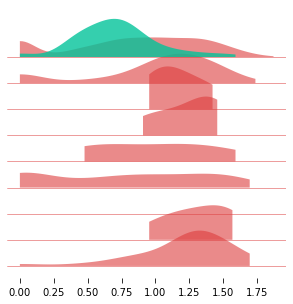

In [116]:
# create a distribution of plant heights per biome
# columns species, shape, StemHeightBladeLength, tip_name
"""
 '1_Tropical_and_subtropical_moist_broadleaf_forests',
 '2_Tropical_and_subtropical_dry_broadleaf_forests',
 '3_Tropical_and_subtropical_coniferous_forests',
 '4_Temperate_broadleaf_and_mixed_forests',
 '5_Temperate_coniferous_forest',
 '7_Tropical_and_subtropical_grasslands_savannas_and_shrublands',
 '8_Temperate_grasslands_savannas_and_shrublands',
 '12_Mediterranean_Forests_woodlands_and_scrubs',
 '13_Desert_and_xeric_shrublands',
 """

biome_list=['1_Tropical_and_subtropical_moist_broadleaf_forests', '2_Tropical_and_subtropical_dry_broadleaf_forests', '3_Tropical_and_subtropical_coniferous_forests',
 '4_Temperate_broadleaf_and_mixed_forests', '5_Temperate_coniferous_forest', '7_Tropical_and_subtropical_grasslands_savannas_and_shrublands',
 '8_Temperate_grasslands_savannas_and_shrublands', '12_Mediterranean_Forests_woodlands_and_scrubs', '13_Desert_and_xeric_shrublands']

# cmap=mpl.cm.PuBuGn
# cmap=mpl.cm.viridis
# norm = mpl.colors.Normalize(vmin=0, vmax=len(biome_list))
# colors = [cmap(norm(value)) for value in range(len(biome_list))]
# color_dict=dict(zip(biome_list,colors))
# color_dict
shape_colour_dict={'cospalmate':"#1586DE", #light blue
'entire':'#02c39a', # now greensih, old: "#003480", # dark blue
'pinnate':"#dd3d3d"}

fig,ax=plt.subplots(figsize=(5,5),facecolor='w')

ybase=0
for biome in biome_list[::-1]:
    if biome =='8_Temperate_grasslands_savannas_and_shrublands':
        ax.axhline(ybase,0,1.75,ls='-',lw=0.5,color=shape_colour_dict['pinnate'])
#         print(1,values+xbase)
        ybase+=1
    else:
        # iterates through each column named as biome and select the rows for which presence =True (coded as 1)
        if len((palms_all_variables[(palms_all_variables[biome]==1) & (palms_all_variables['shape']=='entire')]['StemHeightBladeLength'].dropna().astype('float').values)) > 3:
            valuese=palms_all_variables[(palms_all_variables[biome]==1) & (palms_all_variables['shape']=='entire')]['StemHeightBladeLength'].dropna().astype('float').values
            print(len(valuese),biome,'entire')
            kdee=gaussian_kde(valuese)
            x_gride=np.linspace(min(valuese),max(valuese),100)
            ax.fill_between(x_gride,kdee(x_gride)+ybase,ybase,edgecolor='none',facecolor=shape_colour_dict['entire'],alpha=0.8,zorder=1000)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            values=palms_all_variables[(palms_all_variables[biome]==1) & (palms_all_variables['shape'].isin(['cospalmate','pinnate']))]['StemHeightBladeLength'].dropna().astype('float').values
            kde=gaussian_kde(values)
            x_grid=np.linspace(min(values),max(values),100)
            ax.fill_between(x_grid,kde(x_grid)+ybase,ybase,edgecolor='none',facecolor=shape_colour_dict['pinnate'],alpha=0.6)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.axhline(ybase,0,1.75,ls='-',lw=0.5,color=shape_colour_dict['pinnate'])
        else:
            values=palms_all_variables[(palms_all_variables[biome]==1) & (palms_all_variables['shape'].isin(['cospalmate','pinnate']))]['StemHeightBladeLength'].dropna().astype('float').values
            kde=gaussian_kde(values)
            x_grid=np.linspace(min(values),max(values),100)
            ax.fill_between(x_grid,kde(x_grid)+ybase,ybase,edgecolor='none',facecolor=shape_colour_dict['pinnate'],alpha=0.6)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.axhline(ybase,0,1.75,ls='-',lw=0.5,color=shape_colour_dict['pinnate'])

#         else:
#             values=palms_all_variables[(palms_all_variables[biome]==1) & (palms_all_variables['shape'].isin(['cospalmate','pinnate']))]['StemHeightBladeLength'].dropna().astype('float').values
#             print(len(valuese),biome,'pinnate')
#             kde=gaussian_kde(values)
#             x_grid=np.linspace(min(values),max(values),100)
#             ax.fill_between(x_grid,kde(x_grid)+ybase,ybase,edgecolor=shape_colour_dict['pinnate'],facecolor=shape_colour_dict['pinnate'],alpha=0.6)
#             ax.spines['top'].set_visible(False)
#             ax.spines['right'].set_visible(False)
#             ax.axhline(ybase,0,1.75,ls='-',lw=0.5,color=shape_colour_dict['pinnate'])
        ybase+=1
    #     ax.set_xlabel('%s'%(variable_dict[variables[xx]]))
# plt.ylim(0,len(biome_list)+1)
[ax.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]
ax.tick_params(axis='x',size=5,labelsize=10)
ax.tick_params(axis='y',size=0)
# ax.set_xticklabels([])
ax.set_yticklabels([])
# plt.savefig('./plantsize_perhabitat.pdf',bpi=300)
plt.show()

# Writing R's script files to run the models in a cluster

In [142]:
var_touse=['bio1_stand','bio4_stand','bio12_stand','bio15_stand','aridity_stand','StemHeightBladeLength_stand', 'MaxLeafNumber_stand',
           'Max_Rachis_Length_m_stand','nutrient_avail_stand','rooting_conditions_stand','workability_stand']

cont_var=var_touse
# cat_var=['%s_binned'%(x) for x in soil_data]
shapes=palms_all_variables[palms_all_variables['shape']!='']['shape'].unique()
shapes=['cospalmate' if x=='cos-palmate' else x for x in shapes] # changes cos-palmate to cospalmate, R is stupid
shapes_pairwise=['cospalmate','pinnate','entire']
path=os.getcwd()
a=1

        
for var in cont_var:
    for shape in itertools.combinations(shapes_pairwise, 2):
#         print(shape[0],shape[1])
        # open file to write
        file=open(os.path.join('%s/pairwise_mcmcglmmRAM/'%(path),'Index%03d_Shape-%s_vs_%s_var-%s.R'%(a,shape[0],shape[1],var)),'a')
#####################################################
#         # write code for R
        file.write('library(ape)\n')
        file.write('library(phytools)\n')
        file.write('library(MCMCglmmRAM)\n')
        
        file.write('completeFun <- function(data, desiredCols) {\n')
        file.write('\tcompleteVec <- complete.cases(data[, desiredCols])\n')
        file.write('\treturn(data[completeVec, ])\n')
        file.write('}\n')

        file.write('dataall<-read.csv("../palms_alltraits_curated_20210210.csv",quote="",sep="\\t",header=TRUE)\n')
#         file.write('dataall<-read.csv("./palms_alltraits_curated_20200331.csv",quote="",sep="\\t",header=TRUE)\n')

        file.write('posdis42<-read.tree("../Clean_1_42presampled.trees")\n')
#         file.write('posdis42<-read.tree("./Clean_1_42presampled.trees")\n')    
        file.write('data_%s_pre<-completeFun(dataall,"%s")\n'%(var,var))

#         file.write('data_%s_pre<-na.omit(object= dataall, cols="%s")\n'%(var,var))
# what to filter by
        file.write('filter<-c("%s","%s")\n'%(shape[0],shape[1]))        
        # filter dataset to select the two shapes.
        file.write('data_%s<-subset(data_%s_pre,shape %%in%% filter)\n'%(var,var))
        file.write('rownames(data_%s) <- data_%s$tip_name\n'%(var,var))
        
        file.write('data_%s$%s_binomial<-factor(data_%s$%s_binomial)\n'%(var,shape[0],var,shape[0]))
        ## this should be different for categorical data. See cell below
        file.write('data_%s$%s<-as.numeric(data_%s$%s)\n'%(var,var,var,var))
        file.write('tree1<-posdis42[[1]]\n')
        file.write('missingspp<-setdiff(sort(tree1$tip.label),sort(data_%s$tip_name))\n'%(var))
        
        file.write('data_%s$animal <- factor(data_%s$tip_name)\n'%(var,var)) ## species_python changed to tip_species
        file.write('Nburn <- 9000 #10000\n')
        file.write('Nnitt <- 2000000 #1010000\n')
        file.write('Nthin <- 2000 #1000\n')
        file.write('k <- 2\n')
        file.write('I <- diag(k-1)\n')
        file.write('J <- matrix(rep(1, (k-1)^2), c(k-1, k-1))\n')

        file.write('priors<-list(R=list(V=(1/k)*(I+J), fix=1), G=list(G1=list(V=diag(k-1), nu=0.002)))\n')
        file.write('n_tree=42\n')
        file.write('bio1_postdist<-c()\n')
        
        file.write('for(tree in 1:n_tree){\n')
        file.write('\ttree2<-drop.tip(posdis42[[tree]],c(missingspp))\n')
        file.write('\tmodelbio1<- MCMCglmm(%s_binomial~%s,\n'%(shape[0],var))
        file.write('\t\t\trandom = ~animal,\n')
        file.write('\t\t\tdata = data_%s,\n'%(var))
        file.write('\t\t\treduced = TRUE,\n')
        file.write('\t\t\tpedigree = tree2,\n')
        file.write('\t\t\tfamily = "threshold",\n')
        file.write('\t\t\tprior = priors,\n')
        file.write('\t\t\tverbose = TRUE,\n')
        file.write('\t\t\tburnin = Nburn, nitt = Nnitt, thin = Nthin,\n')
        file.write('\t\t\tpr = TRUE, pl = TRUE, saveX = TRUE,  saveZ = TRUE)\n')
        file.write('\tbio1_postdist<-rbind(bio1_postdist,modelbio1$Sol)\n')
        file.write('}\n')

#         file.write('write.table(bio1_postdist,"./pairwise_mcmcglmmRAM/Shape-%s_var-%s_postdist.txt",sep="\\t")\n'%(shape,var))
#         file.write('save.image("./pairwise_mcmcglmmRAM/Shape-%s_var-%s.Rimage")\n'%(shape,var))
        
        file.write('write.table(bio1_postdist,"./Shape-%s_vs_%s_var-%s_postdist.txt",sep="\\t")\n'%(shape[0],shape[1],var))
        file.write('save.image("./Shape-%s_vs_%s_var-%s.Rimage")\n'%(shape[0],shape[1],var))
        file.close()
        a=a+1

In [ ]:
%%bash

#!/bin/bash
#SBATCH -A SNIC2020-9-1
#SBATCH -J Bio4_glmm
#SBATCH -N 1
#SBATCH -n 10
#SBATCH -t 1-02:00:00
#SBATCH --error=job.%J.err
#SBATCH --output=job.%J.out

echo "Starting at `date`"

module load GCC/6.4.0-2.28  OpenMPI/2.1.2;
module load R/3.4.4-X11-20180131;

# t-an01 [~/pfs]$ FILES=(round1/Index*)
# t-an01 [~/pfs]$ echo ${FILES[001]}
# round1/Index002_Shape-cos-palmate_var-bio1.R
# t-an01 [~/pfs]$ echo ${FILES[000]}
# round1/Index001_Shape-pinnate_var-bio1.R


FILES=(round1/Index*)

R CMD BATCH --no-save --no-restore ${FILES[${SLURM_ARRAY_TASK_ID}]};

echo "Program finished with exit code $? at: `date`"


## 12. Miscelaneous

### Missing data by variable

In [144]:
var_touse=['bio1_stand','bio4_stand','bio12_stand','bio15_stand','aridity_stand','StemHeightBladeLength_stand', 'MaxLeafNumber_stand',
           'Max_Rachis_Length_m_stand','nutrient_avail_stand','rooting_conditions_stand','workability_stand']
palms_all_variables[var_touse].describe()

## missing values
palms_all_variables[var_touse].isna().describe()
# from a total of

,bio1_stand,bio4_stand,bio12_stand,bio15_stand,aridity_stand,StemHeightBladeLength_stand,MaxLeafNumber_stand,Max_Rachis_Length_m_stand,nutrient_avail_stand,rooting_conditions_stand,workability_stand
count,2624,2624,2624,2624,2624,2624,2624,2624,2624,2624,2624
unique,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,True,True,False,False,False
freq,1508,1508,1508,1508,1508,2157,1340,1403,1508,1508,1508


# Information and missing data stats

In [150]:
# palms['StemHeight+BladeLength'].isna().describe()
palms_all_variables[['StemHeightBladeLength_stand', 'MaxLeafNumber_stand','Max_Rachis_Length_m_stand']].describe()

,StemHeightBladeLength_stand,MaxLeafNumber_stand,Max_Rachis_Length_m_stand
count,2.157000e+03,1.284000e+03,1.221000e+03
mean,-1.120002e-16,9.960879e-17,1.047483e-16
std,1.000232e+00,1.000390e+00,1.000410e+00
min,-1.567117e+00,-1.869907e+00,-1.732005e+00
25%,-6.872759e-01,-7.347829e-01,-8.195594e-01
50%,9.572194e-02,-1.792158e-01,-8.923953e-02
75%,8.021435e-01,6.038121e-01,7.036622e-01
max,2.115443e+00,3.385416e+00,3.800606e+00


In [151]:
no_misingdata=palms_all_variables[['StemHeightBladeLength', 'MaxLeafNumber']].isna().describe().loc['freq']
misingdata=2512-no_misingdata
print('Missing data:\n',misingdata,'\n')
print('No missing data:\n',no_misingdata,'\n')

Missing data:
 StemHeightBladeLength     355
MaxLeafNumber            1172
Name: freq, dtype: object 

No missing data:
 StemHeightBladeLength    2157
MaxLeafNumber            1340
Name: freq, dtype: object 

